# Supervised Multi-Class Fault Classification using Transformer-Kalman Hybrid Model

This Jupyter Notebook  is part of the Supporting Information for the paper *Benchmarking Machine Learning Anomaly Detection Methods on the Tennessee Eastman Process Dataset* by Naixin Lyu, Suraj Botcha, Eesha Kulkarni, Shreya Pagaria, Ethan M. Sunshine, Victor Alves, John R. Kitchin.

This notebook implements a supervised learning approach for multi-class fault classification in the Tennessee Eastman Process (TEP) dataset, combining a Transformer-based neural network architecture with Kalman filtering to classify 18 different fault types. The implementation uses PyTorch for model development, with a Transformer encoder architecture[[1]](#1) featuring multi-head attention mechanisms and employing several regularization techniques including dropout (0.3), weight decay (1e-3), label smoothing (0.1), gradient clipping, and early stopping (patience=7) to prevent overfitting, while the training process incorporates learning rate scheduling, with post-processing performed using a Kalman filter[[2]](#2) with forward-only filtering, sliding window voting, and adaptive parameters to improve classification stability. The model is trained on 323,200 samples, validated on 161,600 samples, and tested on 434,400 samples, where the dataset includes 52 process variables (sensor measurements and manipulated variables) for each sample, with a sliding window approach (lookback=30) used for temporal feature extraction.

In the interest of methodological transparency, we note that a large language model (e.g., Claude) was used in a limited capacity during the refinement of this notebook. The core algorithms and logic were written by the human authors. The LLM's role was restricted to assisting with adding comments and organizing the code structure to improve its readability and maintainability. All outputs were reviewed and validated by the authors.

The classification performance and results are shown in **Table 3**, **Figure 2**, and **Figure 3**. Please see following code, comments and narrative text to understand and use the workflow.

In [3]:
try:
    from google.colab import drive
    drive.mount('/content/drive')

    # You have to update this for the location of this notebook in your Google Drive
    import os
    os.chdir('/content/drive/MyDrive/research/time-series-anomaly-detection/TEP-anomaly-detection-manuscript/supporting-information')
except:
    print('Running locally')
    pass

Mounted at /content/drive


In [4]:
import time
t0 = time.time() # for elapsed time

## Imports & global setup

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import gc
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, precision_recall_fscore_support
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.preprocessing import label_binarize
from tqdm import tqdm
import os
import time
import pickle
import seaborn as sns

# Set random seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set device for PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Load datasets

In [6]:
# Load datasets
df_train = pd.read_csv("../Dataset/new_data/supervised_train_new.csv")
df_val = pd.read_csv("../Dataset/new_data/supervised_val_new.csv")
df_test = pd.read_csv("../Dataset/new_data/supervised_test_new.csv")

print("Dataset shapes:")
print(f"Training: {df_train.shape}")
print(f"Validation: {df_val.shape}")
print(f"Testing: {df_test.shape}")

print("\nDataset info:")
print(f"Training fault types: {sorted(df_train['faultNumber'].unique())}")
print(f"Validation fault types: {sorted(df_val['faultNumber'].unique())}")
print(f"Testing fault types: {sorted(df_test['faultNumber'].unique())}")

print(f"\nColumn names (first 10): {df_train.columns[:10].tolist()}")
print(f"Process variables (columns 4-55): {df_train.columns[3:55].tolist()[:10]}...")

# Check class distribution
print(f"\nClass distribution in training set:")
print(df_train['faultNumber'].value_counts().sort_index())

Dataset shapes:
Training: (323200, 57)
Validation: (161600, 57)
Testing: (434400, 57)

Dataset info:
Training fault types: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0)]
Validation fault types: [np.float64(0.0), np.float64(1.0), np.float64(2.0), np.float64(4.0), np.float64(5.0), np.float64(6.0), np.float64(7.0), np.float64(8.0), np.float64(10.0), np.float64(11.0), np.float64(12.0), np.float64(13.0), np.float64(14.0), np.float64(16.0), np.float64(17.0), np.float64(18.0), np.float64(19.0), np.float64(20.0)]
Testing fault types: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(

## Data preprocessing helper

In [7]:
def preprocess_data(df, scaler=None, label_encoder=None, fit_scaler=False, fit_encoder=False):
    """
    Preprocess the dataset by extracting features and encoding labels
    """
    # Extract process variables
    X = df.iloc[:, 3:55].values

    # Extract fault labels directly
    y = df['faultNumber'].values

    # Scale features
    if fit_scaler:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        return_scaler = scaler
    elif scaler is not None:
        X_scaled = scaler.transform(X)
        return_scaler = scaler
    else:
        X_scaled = X
        return_scaler = None

    # Encode labels
    if fit_encoder:
        label_encoder = LabelEncoder()
        y_encoded = label_encoder.fit_transform(y)
        return_encoder = label_encoder
        print(f"Label encoder classes: {label_encoder.classes_}")
        print(f"Number of unique classes: {len(label_encoder.classes_)}")
    elif label_encoder is not None:
        # Handle the case where test set might have missing classes
        try:
            y_encoded = label_encoder.transform(y)
            return_encoder = label_encoder
        except ValueError as e:
            print(f"Warning: {e}")
            # Filter out unseen labels
            seen_labels = set(label_encoder.classes_)
            mask = np.isin(y, list(seen_labels))
            if not np.all(mask):
                print(f"Filtering out {np.sum(~mask)} samples with unseen labels")
                X_scaled = X_scaled[mask]
                y = y[mask]
            y_encoded = label_encoder.transform(y)
            return_encoder = label_encoder
    else:
        y_encoded = y
        return_encoder = None

    if fit_scaler or fit_encoder:
        return X_scaled, y_encoded, return_scaler, return_encoder
    else:
        return X_scaled, y_encoded

## Kalman Filter implementation

In [8]:
class KalmanFilter:
    """Kalman Filter (no future information used)"""
    def __init__(self, dim_x, Q=1e-5, R=0.1):
        self.dim_x = dim_x
        self.Q_base = Q
        self.R_base = R
        self.transition_threshold = 0.25
        self.confidence_threshold = 0.65
        self.stabilization_steps = 3
        self.vote_window = 5

    def filter(self, predictions, class_labels=None):
        n = len(predictions)
        if n == 0:
            return predictions
        if len(predictions.shape) > 1:
            forward_filtered = self._filter_forward(predictions)
            smoothed = self._sliding_window_smooth(forward_filtered)
            refined = self._refine_boundaries(smoothed, predictions)
            return refined
        else:
            return self._filter_1d_adaptive(predictions, class_labels)

    def _filter_forward(self, probs):
        """Forward Kalman filter"""
        n = len(probs)
        num_classes = probs.shape[1]
        filtered = np.zeros_like(probs)
        x_est = np.zeros((n, num_classes))
        P = np.ones((n, num_classes))
        x_est[0] = probs[0]
        filtered[0] = probs[0]
        steps_since_transition = 100
        prev_class = np.argmax(probs[0])

        for k in range(1, n):
            curr_obs = probs[k]
            curr_class = np.argmax(curr_obs)
            curr_conf = np.max(curr_obs)
            entropy = self._compute_entropy(curr_obs)
            is_transition = self._detect_transition(x_est[k-1], curr_obs, prev_class, curr_class)

            if is_transition:
                steps_since_transition = 0
                prev_class = curr_class
            else:
                steps_since_transition += 1

            Q, R = self._get_adaptive_params(steps_since_transition, curr_conf, entropy)

            for c in range(num_classes):
                x_pred = x_est[k-1, c]
                P_pred = P[k-1, c] + Q
                K = P_pred / (P_pred + R)
                x_est[k, c] = x_pred + K * (curr_obs[c] - x_pred)
                P[k, c] = (1 - K) * P_pred
            filtered[k] = x_est[k]

        filtered = filtered / (filtered.sum(axis=1, keepdims=True) + 1e-10)
        return filtered

    def _sliding_window_smooth(self, probs):
        """sliding window smoothing"""
        n = len(probs)
        num_classes = probs.shape[1]
        smoothed = probs.copy()
        window_size = self.vote_window

        for k in range(window_size - 1, n):
            window_start = k - window_size + 1
            window_end = k + 1
            window_probs = probs[window_start:window_end]
            window_preds = np.argmax(window_probs, axis=1)
            weights = np.arange(1, window_size + 1, dtype=float)
            weights = weights / weights.sum()

            vote_counts = np.zeros(num_classes)
            for i, pred in enumerate(window_preds):
                vote_counts[pred] += weights[i] * np.max(window_probs[i])

            voted_class = np.argmax(vote_counts)
            current_class = np.argmax(probs[k])

            if voted_class != current_class:
                vote_confidence = vote_counts[voted_class] / (vote_counts.sum() + 1e-10)
                current_confidence = np.max(probs[k])
                if vote_confidence > current_confidence:
                    boost = min(0.25, vote_confidence - current_confidence)
                    smoothed[k, voted_class] += boost
                    smoothed[k, current_class] -= boost * 0.5
                    smoothed[k] = np.clip(smoothed[k], 0.01, 0.99)
                    smoothed[k] /= smoothed[k].sum()
        return smoothed

    def _refine_boundaries(self, probs, original):
        """boundary refinement"""
        n = len(probs)
        refined = probs.copy()
        predictions = np.argmax(probs, axis=1)

        # Detect boundaries
        for k in range(1, n):
            if predictions[k] != predictions[k-1]:
                # Boundary detected at k
                pre_state = predictions[k-1]
                post_state = predictions[k]
                boundary_prob_pre = original[k, pre_state]
                boundary_prob_post = original[k, post_state]

                # If previous state has higher probability at current time, adjust
                if boundary_prob_pre > boundary_prob_post + 0.1:
                    refined[k, pre_state] += 0.15
                    refined[k, post_state] -= 0.1
                    refined[k] = np.clip(refined[k], 0.01, 0.99)
                    refined[k] /= refined[k].sum()
        return refined

    def _compute_entropy(self, probs):
        """Compute normalized entropy of probability distribution"""
        probs = np.clip(probs, 1e-10, 1.0)
        entropy = -np.sum(probs * np.log(probs))
        max_entropy = np.log(len(probs))
        return entropy / max_entropy if max_entropy > 0 else 0

    def _detect_transition(self, prev_state, curr_obs, prev_class, curr_class):
        """Detect state transition based on probability changes"""
        if curr_class == prev_class:
            return False
        curr_conf = np.max(curr_obs)
        prev_class_drop = prev_state[prev_class] - curr_obs[prev_class]
        prob_change = np.abs(curr_obs - prev_state).max()
        if curr_conf > self.confidence_threshold and prev_class_drop > 0.15:
            return True
        if prob_change > self.transition_threshold and curr_conf > 0.5:
            return True
        return False

    def _get_adaptive_params(self, steps_since_transition, confidence, entropy):
        """Get adaptive Q and R parameters based on current state"""
        entropy_factor = 1 + entropy * 0.5
        if steps_since_transition == 0:
            Q = self.Q_base * 500
            R = self.R_base * 0.1 * entropy_factor
        elif steps_since_transition <= self.stabilization_steps:
            decay = steps_since_transition / self.stabilization_steps
            Q = self.Q_base * (50 * (1 - decay) + 1)
            R = self.R_base * (0.3 + 0.7 * decay) * entropy_factor
        else:
            conf_factor = max(0.3, 1.3 - confidence)
            Q = self.Q_base
            R = self.R_base * conf_factor * entropy_factor
        return Q, R

    def _filter_1d_adaptive(self, y_noisy, class_labels=None):
        """1D adaptive Kalman filter"""
        n = len(y_noisy)
        x_est = np.zeros(n)
        P = np.zeros(n)
        if n > 0:
            x_est[0] = y_noisy[0]
            P[0] = 1.0
        steps = 100
        for k in range(1, n):
            if abs(y_noisy[k] - x_est[k-1]) > self.transition_threshold:
                steps = 0
            else:
                steps += 1
            Q, R = self._get_adaptive_params(steps, 0.7, 0.3)
            x_pred = x_est[k-1]
            P_pred = P[k-1] + Q
            K = P_pred / (P_pred + R)
            x_est[k] = x_pred + K * (y_noisy[k] - x_pred)
            P[k] = (1 - K) * P_pred
        return x_est

## Dataset & windowing

In [9]:
class MultiClassDataset(Dataset):
    """Dataset for multi-class classification"""
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

def create_time_series_windows(X, y, lookback=30, max_samples=None, start_idx=0):
    """Create sliding window dataset for time series classification"""
    n_potential_samples = len(X) - lookback + 1 - start_idx
    n_samples = max(0, n_potential_samples)

    if max_samples is not None and n_samples > max_samples:
        n_samples = max_samples

    if n_samples == 0:
        return torch.tensor([], dtype=torch.float32).reshape(0, lookback, X.shape[1]), torch.tensor([], dtype=torch.long)

    n_features = X.shape[1]
    X_windows = np.zeros((n_samples, lookback, n_features), dtype=np.float32)
    y_windows = np.zeros(n_samples, dtype=np.int64)

    for i in tqdm(range(n_samples), desc="Creating windows",
                  miniters=int(n_samples/100) if n_samples > 100 else 1, leave=False):
        actual_idx = start_idx + i
        X_windows[i] = X[actual_idx : actual_idx + lookback]
        y_windows[i] = y[actual_idx + lookback - 1]

    return torch.tensor(X_windows, dtype=torch.float32), torch.tensor(y_windows, dtype=torch.long)

def create_time_series_windows_from_df(df, scaler, label_encoder,
                                       lookback=30,
                                       group_cols=('faultNumber', 'simulationRun'),
                                       return_run_indices=False):
    """
    Create time series windows from dataframe, grouped by simulation runs
    """
    feature_cols = df.columns[3:55]
    X_list = []
    y_list = []
    run_indices_list = []
    run_id = 0

    for _, group in df.groupby(list(group_cols)):
        if 'sample' in group.columns:
            group = group.sort_values('sample')

        if len(group) < lookback:
            continue

        X = group[feature_cols].values
        X_scaled = scaler.transform(X)
        y_raw = group['faultNumber'].values
        y_enc = label_encoder.transform(y_raw)

        n_samples = len(group) - lookback + 1
        for i in range(n_samples):
            X_list.append(X_scaled[i:i+lookback])
            y_list.append(y_enc[i + lookback - 1])
            run_indices_list.append(run_id)

        run_id += 1

    if not X_list:
        n_features = len(feature_cols)
        empty_X = torch.empty((0, lookback, n_features), dtype=torch.float32)
        empty_y = torch.empty((0,), dtype=torch.long)
        if return_run_indices:
            return empty_X, empty_y, np.array([], dtype=np.int64)
        return empty_X, empty_y

    X_arr = np.stack(X_list).astype(np.float32)
    y_arr = np.array(y_list, dtype=np.int64)

    if return_run_indices:
        run_indices_arr = np.array(run_indices_list, dtype=np.int64)
        return torch.tensor(X_arr, dtype=torch.float32), torch.tensor(y_arr, dtype=torch.long), run_indices_arr

    return torch.tensor(X_arr, dtype=torch.float32), torch.tensor(y_arr, dtype=torch.long)

## Positional Encoding

In [10]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    """
    Positional encoding for Transformer model
    """
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Create positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        """Add positional encoding to input"""
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

## Transformer classifier

In [11]:
class TransformerClassifier(nn.Module):
    """
    Transformer-based classifier for multi-class fault detection with enhanced regularization
    """
    def __init__(self, input_dim, num_classes, d_model=32, nhead=2, num_layers=1, dropout=0.3):
        """
        Initialize Transformer classifier with reduced complexity to prevent overfitting
        """
        super().__init__()

        self.num_classes = num_classes
        self.d_model = d_model  # Store d_model for forward pass

        # Input embedding with dropout
        self.embedding = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.Dropout(dropout)
        )

        # Positional encoding
        self.pos_encoder = PositionalEncoding(d_model, dropout)

        # Transformer encoder layers with reduced complexity
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=d_model * 2,
            dropout=dropout,
            batch_first=True
        )

        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classification head with enhanced regularization
        self.classifier = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(64),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.BatchNorm1d(32),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        """
        Forward pass of the model
        """
        batch_size, seq_len, _ = x.size()

        # Embedding and scale - use self.d_model instead of self.embedding.out_features
        x_embedded = self.embedding(x) * np.sqrt(self.d_model)

        # Add positional encoding
        x_embedded = self.pos_encoder(x_embedded)

        # Pass through transformer encoder
        x_encoded = self.transformer_encoder(x_embedded)

        # Global pooling over sequence dimension
        x_pooled = self.global_pool(x_encoded.transpose(1, 2)).squeeze(-1)

        # Classification
        logits = self.classifier(x_pooled)

        return logits

## EarlyStopping utility

In [12]:
class EarlyStopping:
    """
    Early stopping to stop training when validation loss doesn't improve
    """
    def __init__(self, patience=7, min_delta=0.001, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None

    def __call__(self, val_loss, model):
        """
        Call early stopping check
        """
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1

        if self.counter >= self.patience:
            if self.restore_best_weights:
                self.restore_checkpoint(model)
            return True
        return False

    def save_checkpoint(self, model):
        """Save model checkpoint"""
        self.best_weights = model.state_dict().copy()

    def restore_checkpoint(self, model):
        """Restore best model weights"""
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)

## MultiClassFaultClassifier

In [13]:
class MultiClassFaultClassifier:
    """
    Multi-class fault classifier using Transformer + Kalman filter
    """
    def __init__(self, input_dim, num_classes, d_model=64, nhead=4, num_layers=2, dropout=0.1, Q=1e-5, R=0.1):
        self.model = TransformerClassifier(input_dim, num_classes, d_model, nhead, num_layers, dropout)
        self.kalman_filter = KalmanFilter(1, Q, R)
        self.device = device
        self.model.to(self.device)
        self.num_classes = num_classes

        # Training related variables
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        self.epochs = []
        self.current_epoch = 0

        # Checkpoint directory
        self.checkpoint_dir = 'checkpoints'
        os.makedirs(self.checkpoint_dir, exist_ok=True)

    def save_checkpoint(self, epoch, optimizer, loss, accuracy, filename=None):
        """Save model checkpoint with enhanced information"""
        if filename is None:
            filename = f'multiclass_classifier_checkpoint.pth'
        path = os.path.join(self.checkpoint_dir, filename)

        checkpoint_dict = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'loss': loss,
            'accuracy': accuracy,
            'train_losses': self.train_losses,
            'val_losses': self.val_losses,
            'train_accuracies': self.train_accuracies,
            'val_accuracies': self.val_accuracies,
            'learning_rates': self.learning_rates,
            'epochs': self.epochs,
            'current_epoch': self.current_epoch,
            'num_classes': self.num_classes,
            'best_val_loss': self.best_val_loss,
            'early_stopped_epoch': getattr(self, 'early_stopped_epoch', None)
        }

        if optimizer is not None:
            try:
                checkpoint_dict['optimizer_state_dict'] = optimizer.state_dict()
            except AttributeError:
                print("Warning: optimizer does not have state_dict method")

        torch.save(checkpoint_dict, path)
        print(f"Checkpoint saved at {path}")

    def load_checkpoint(self, optimizer, filename=None):
        """Load model checkpoint with enhanced information"""
        if filename is None:
            filename = f'multiclass_classifier_checkpoint.pth'
        path = os.path.join(self.checkpoint_dir, filename)

        if os.path.exists(path):
            checkpoint = torch.load(path, map_location=self.device)
            self.model.load_state_dict(checkpoint['model_state_dict'])

            if optimizer is not None and 'optimizer_state_dict' in checkpoint:
                optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

            self.train_losses = checkpoint.get('train_losses', [])
            self.val_losses = checkpoint.get('val_losses', [])
            self.train_accuracies = checkpoint.get('train_accuracies', [])
            self.val_accuracies = checkpoint.get('val_accuracies', [])
            self.learning_rates = checkpoint.get('learning_rates', [])
            self.epochs = checkpoint.get('epochs', [])
            self.current_epoch = checkpoint.get('current_epoch', 0)
            self.num_classes = checkpoint.get('num_classes', self.num_classes)
            self.best_val_loss = checkpoint.get('best_val_loss', float('inf'))
            self.early_stopped_epoch = checkpoint.get('early_stopped_epoch', None)

            start_epoch_for_loop = self.current_epoch + 1 if self.epochs else 0
            print(f"Checkpoint loaded from {path}, resuming from epoch {start_epoch_for_loop}")

            if self.early_stopped_epoch:
                print(f"Previous training was early stopped at epoch {self.early_stopped_epoch}")

            return start_epoch_for_loop, checkpoint.get('loss', float('inf')), checkpoint.get('accuracy', 0.0)
        else:
            print(f"No checkpoint found at {path}, starting from scratch")
            # Ensure attributes are properly initialized when no checkpoint exists
            self.best_val_loss = float('inf')
            self.early_stopped_epoch = None
            return 0, float('inf'), 0.0

    def validate(self, val_loader, criterion):
        """Validate model on validation set"""
        self.model.eval()
        total_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)

                outputs = self.model(X_batch)
                loss = criterion(outputs, y_batch)

                total_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        avg_val_loss = total_loss / len(val_loader) if len(val_loader) > 0 else 0.0
        val_accuracy = correct / total if total > 0 else 0.0

        return avg_val_loss, val_accuracy

    def train_model(self, train_loader, val_loader=None, num_epochs=30, lr=5e-4,
                   resume=True, save_interval=5, patience=7, use_scheduler=True):
        """
        Train the multi-class classifier with overfitting prevention
        """
        # Enhanced optimizer with weight decay
        criterion = nn.CrossEntropyLoss(label_smoothing=0.1)  # Label smoothing for regularization
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=lr, weight_decay=1e-3)

        # Learning rate scheduler
        if use_scheduler:
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=0.5, patience=3, min_lr=1e-6
            )

        # Early stopping
        early_stopping = EarlyStopping(patience=patience, min_delta=0.001, restore_best_weights=True)

        start_epoch_idx = 0
        best_loss = float('inf')
        best_accuracy = 0.0

        if resume:
            start_epoch_idx, best_loss, best_accuracy = self.load_checkpoint(optimizer)

        if start_epoch_idx == 0 and not self.epochs:
            self.train_losses = []
            self.val_losses = []
            self.train_accuracies = []
            self.val_accuracies = []
            self.learning_rates = []
            self.epochs = []
            self.current_epoch = -1
            self.best_val_loss = float('inf')  # Reset best validation loss
            self.early_stopped_epoch = None   # Reset early stopping epoch

        self.model.train()
        training_interrupted = False
        early_stopped = False

        print(f"Training multi-class fault classifier with overfitting prevention...")
        print(f"Training batches: {len(train_loader)}")
        if val_loader:
            print(f"Validation batches: {len(val_loader)}")
        print(f"Early stopping patience: {patience}")
        print(f"Initial learning rate: {lr}")
        print(f"Weight decay: 1e-3")
        print(f"Label smoothing: 0.1")

        for epoch_iter in range(num_epochs):
            current_training_epoch = start_epoch_idx + epoch_iter
            self.current_epoch = current_training_epoch
            epoch_start_time = time.time()
            total_loss = 0.0
            correct = 0
            total = 0

            # Record current learning rate
            current_lr = optimizer.param_groups[0]['lr']
            self.learning_rates.append(current_lr)

            batch_pbar = tqdm(train_loader,
                            desc=f"Epoch {current_training_epoch+1}/{start_epoch_idx + num_epochs} (LR: {current_lr:.2e})",
                            leave=False)

            try:
                for batch_idx, (X_batch, y_batch) in enumerate(batch_pbar):
                    X_batch, y_batch = X_batch.to(self.device), y_batch.to(self.device)
                    optimizer.zero_grad()
                    outputs = self.model(X_batch)
                    loss = criterion(outputs, y_batch)
                    loss.backward()

                    # Gradient clipping to prevent exploding gradients
                    torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)

                    optimizer.step()

                    total_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    total += y_batch.size(0)
                    correct += (predicted == y_batch).sum().item()

                    batch_pbar.set_postfix({
                        "batch_loss": f"{loss.item():.4f}",
                        "batch_acc": f"{100.0 * (predicted == y_batch).sum().item() / y_batch.size(0):.2f}%",
                        "lr": f"{current_lr:.2e}"
                    })

                avg_train_loss = total_loss / len(train_loader) if len(train_loader) > 0 else 0.0
                train_accuracy = correct / total if total > 0 else 0.0

                self.train_losses.append(avg_train_loss)
                self.train_accuracies.append(train_accuracy)
                self.epochs.append(current_training_epoch + 1)

                avg_val_loss = None
                val_accuracy = None
                if val_loader:
                    avg_val_loss, val_accuracy = self.validate(val_loader, criterion)
                    self.val_losses.append(avg_val_loss)
                    self.val_accuracies.append(val_accuracy)

                    # Update best validation loss
                    if avg_val_loss < self.best_val_loss:
                        self.best_val_loss = avg_val_loss

                epoch_time = time.time() - epoch_start_time
                status = f"Epoch {current_training_epoch+1}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}"
                if avg_val_loss is not None:
                    status += f", Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}"
                status += f", Time: {epoch_time:.2f}s, LR: {current_lr:.2e}"
                print(status)

                # Learning rate scheduling
                if use_scheduler and avg_val_loss is not None:
                    old_lr = optimizer.param_groups[0]['lr']
                    scheduler.step(avg_val_loss)
                    new_lr = optimizer.param_groups[0]['lr']
                    if new_lr != old_lr:
                        print(f"Learning rate reduced from {old_lr:.2e} to {new_lr:.2e}")

                # Early stopping check
                if val_loader and early_stopping(avg_val_loss, self.model):
                    print(f"\nEarly stopping triggered at epoch {current_training_epoch + 1}")
                    print(f"Best validation loss was {early_stopping.best_loss:.6f}")
                    self.early_stopped_epoch = current_training_epoch + 1
                    early_stopped = True

                    # Save early stopped model
                    self.save_checkpoint(current_training_epoch + 1, optimizer, avg_train_loss, train_accuracy,
                                       f'multiclass_classifier_early_stopped_epoch_{current_training_epoch+1}.pth')
                    break

                # Plot training progress every 5 epochs
                if (current_training_epoch + 1) % 5 == 0 or early_stopped:
                    self.plot_training_progress(current_training_epoch + 1)

                # Save checkpoint
                if (current_training_epoch + 1) % save_interval == 0:
                    self.save_checkpoint(current_training_epoch + 1, optimizer, avg_train_loss, train_accuracy,
                                       f'multiclass_classifier_checkpoint_epoch_{current_training_epoch+1}.pth')

                # Save best model
                current_eval_metric = val_accuracy if val_accuracy is not None else train_accuracy
                if current_eval_metric > best_accuracy:
                    best_accuracy = current_eval_metric
                    best_loss = avg_val_loss if avg_val_loss is not None else avg_train_loss
                    self.save_checkpoint(current_training_epoch + 1, optimizer, best_loss, best_accuracy,
                                       f'multiclass_classifier_best_model.pth')
                    print(f"New best model saved with accuracy: {best_accuracy:.4f}")

            except KeyboardInterrupt:
                print(f"\nTraining interrupted at epoch {current_training_epoch+1}! Saving checkpoint...")
                training_interrupted = True
                last_loss = total_loss / len(train_loader) if len(train_loader) > 0 else float('inf')
                last_accuracy = correct / total if total > 0 else 0.0
                self.save_checkpoint(current_training_epoch + 1, optimizer, last_loss, last_accuracy,
                                   f'multiclass_classifier_interrupted_checkpoint.pth')
                break

            if training_interrupted or early_stopped:
                break

        # Final save
        if not training_interrupted and self.epochs:
            final_epoch_num = self.epochs[-1]
            final_loss = self.train_losses[-1]
            final_accuracy = self.train_accuracies[-1]
            self.save_checkpoint(final_epoch_num, optimizer, final_loss, final_accuracy,
                               f'multiclass_classifier_final_model.pth')

            if early_stopped:
                print(f"Training completed with early stopping at epoch {self.early_stopped_epoch}!")
            else:
                print(f"Training completed after {final_epoch_num} epochs!")

        return optimizer

    def plot_training_progress(self, current_epoch):
        """Plot enhanced training progress with learning rate"""
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Loss plot
        plot_epochs = self.epochs
        plot_train_losses = self.train_losses[-len(plot_epochs):]
        axes[0].plot(plot_epochs, plot_train_losses, 'b-', label='Training Loss', linewidth=2)

        if self.val_losses:
            val_epochs_x = plot_epochs[-len(self.val_losses):]
            plot_val_losses = self.val_losses
            if len(val_epochs_x) == len(plot_val_losses) and len(val_epochs_x) > 0:
                axes[0].plot(val_epochs_x, plot_val_losses, 'r-', label='Validation Loss', linewidth=2)

                # Mark best validation loss
                if hasattr(self, 'best_val_loss'):
                    best_idx = np.argmin(plot_val_losses)
                    axes[0].plot(val_epochs_x[best_idx], plot_val_losses[best_idx], 'go',
                               markersize=8, label=f'Best Val Loss ({plot_val_losses[best_idx]:.4f})')

        # Mark early stopping point if applicable
        if hasattr(self, 'early_stopped_epoch') and self.early_stopped_epoch:
            axes[0].axvline(self.early_stopped_epoch, color='red', linestyle='--', alpha=0.7,
                           label=f'Early Stop (Epoch {self.early_stopped_epoch})')

        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Progress - Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy plot
        plot_train_accuracies = self.train_accuracies[-len(plot_epochs):]
        axes[1].plot(plot_epochs, plot_train_accuracies, 'b-', label='Training Accuracy', linewidth=2)

        if self.val_accuracies:
            val_epochs_x = plot_epochs[-len(self.val_accuracies):]
            plot_val_accuracies = self.val_accuracies
            if len(val_epochs_x) == len(plot_val_accuracies) and len(val_epochs_x) > 0:
                axes[1].plot(val_epochs_x, plot_val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)

                # Mark best validation accuracy
                best_idx = np.argmax(plot_val_accuracies)
                axes[1].plot(val_epochs_x[best_idx], plot_val_accuracies[best_idx], 'go',
                           markersize=8, label=f'Best Val Acc ({plot_val_accuracies[best_idx]:.4f})')

        if hasattr(self, 'early_stopped_epoch') and self.early_stopped_epoch:
            axes[1].axvline(self.early_stopped_epoch, color='red', linestyle='--', alpha=0.7,
                           label=f'Early Stop (Epoch {self.early_stopped_epoch})')

        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Training Progress - Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Learning rate plot
        if self.learning_rates:
            lr_epochs = plot_epochs[-len(self.learning_rates):]
            plot_learning_rates = self.learning_rates[-len(lr_epochs):]
            axes[2].plot(lr_epochs, plot_learning_rates, 'g-', label='Learning Rate', linewidth=2)
            axes[2].set_xlabel('Epoch')
            axes[2].set_ylabel('Learning Rate')
            axes[2].set_title('Learning Rate Schedule')
            axes[2].set_yscale('log')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)

        plt.tight_layout()
        plt.savefig(f'training_progress_epoch_{current_epoch}.png', dpi=300, bbox_inches='tight')
        plt.close()

    def predict(self, X, batch_size=32, use_kalman=True, run_indices=None):
        """
        Make predictions with optional Kalman filtering
        """
        self.model.eval()

        if isinstance(X, np.ndarray):
            total_samples = X.shape[0]
        elif isinstance(X, torch.Tensor):
            total_samples = X.size(0)
        else:
            raise TypeError("Input X must be a NumPy array or PyTorch Tensor.")

        if total_samples == 0:
            return np.array([]), np.array([]), np.array([]), np.array([])

        all_predictions = []
        all_probabilities = []

        try:
            with torch.no_grad():
                for i in tqdm(range(0, total_samples, batch_size), desc="Predicting", leave=False):
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

                    end_idx = min(i + batch_size, total_samples)
                    if isinstance(X, np.ndarray):
                        X_batch_np = X[i:end_idx]
                        X_tensor = torch.tensor(X_batch_np, dtype=torch.float32).to(self.device)
                    else:
                        X_tensor = X[i:end_idx].to(self.device)

                    outputs = self.model(X_tensor)
                    probabilities = torch.softmax(outputs, dim=1)
                    predictions = torch.argmax(outputs, dim=1)

                    all_predictions.append(predictions.cpu().numpy())
                    all_probabilities.append(probabilities.cpu().numpy())

                    del X_tensor, outputs, probabilities, predictions
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

            predictions = np.concatenate(all_predictions)
            probabilities = np.concatenate(all_probabilities)

            if use_kalman:
                if run_indices is not None:
                    # Apply Kalman filter separately for each run
                    print(f"Applying Adaptive Kalman filter separately for {len(np.unique(run_indices))} runs...")
                    filtered_probabilities = np.zeros_like(probabilities)
                    unique_runs = np.unique(run_indices)

                    for run_id in tqdm(unique_runs, desc="Filtering runs", leave=False):
                        run_mask = (run_indices == run_id)
                        run_probs = probabilities[run_mask]

                        run_preds_raw = predictions[run_mask]

                        if len(run_probs) > 0:
                            filtered_run_probs = self.kalman_filter.filter(
                                run_probs,
                                class_labels=run_preds_raw
                            )
                            filtered_probabilities[run_mask] = filtered_run_probs

                    filtered_predictions = np.argmax(filtered_probabilities, axis=1)
                else:
                    filtered_probabilities = self.kalman_filter.filter(
                        probabilities,
                        class_labels=predictions
                    )
                    filtered_predictions = np.argmax(filtered_probabilities, axis=1)

                return predictions, probabilities, filtered_predictions, filtered_probabilities
            else:
                return predictions, probabilities

        except Exception as e:
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            raise e

## Training wrapper function

In [14]:
def train_model(df_train, df_val, lookback=30, num_epochs=30, batch_size=32):
    """Train multi-class model"""
    try:
        print(f"\n{'='*80}")
        print(f"Training Transformer+Kalman Multi-Class Fault Classifier")
        print(f"{'='*80}")

        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        _, _, scaler, label_encoder = preprocess_data(
            df_train, fit_scaler=True, fit_encoder=True
        )
        print(f"Label encoder classes: {label_encoder.classes_}")
        print(f"Number of unique classes: {len(label_encoder.classes_)}")

        X_train_windows, y_train_windows = create_time_series_windows_from_df(
            df_train, scaler, label_encoder, lookback=lookback,
            group_cols=('faultNumber', 'simulationRun')
        )
        X_val_windows, y_val_windows = create_time_series_windows_from_df(
            df_val, scaler, label_encoder, lookback=lookback,
            group_cols=('faultNumber', 'simulationRun')
        )

        y_train = y_train_windows.numpy()
        y_val = y_val_windows.numpy()

        print(f"Training data windows shape: {X_train_windows.shape}")
        print(f"Number of classes: {len(np.unique(y_train))}")
        print(f"Class distribution (train windows): {np.bincount(y_train)}")

        print(f"Validation windows shape: {X_val_windows.shape}")
        print(f"Validation class distribution (windows): {np.bincount(y_val)}")

        if X_train_windows.nelement() == 0:
            print("Error: No training windows created. Check data length and lookback.")
            return None, None, None

        train_dataset = MultiClassDataset(X_train_windows, y_train_windows)
        val_dataset = MultiClassDataset(X_val_windows, y_val_windows)

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                  drop_last=True if len(train_dataset) > batch_size else False)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

        feature_dim = X_train_windows.shape[2]
        num_classes = len(np.unique(y_train))

        classifier = MultiClassFaultClassifier(
            input_dim=feature_dim,
            num_classes=num_classes,
            d_model=32,
            nhead=2,
            num_layers=1,
            dropout=0.3,
            Q=1e-5,
            R=0.1
        )

        print(f"Model initialized with {feature_dim} input features and {num_classes} classes")

        del X_train_windows, X_val_windows, train_dataset, val_dataset
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Train the model with enhanced overfitting prevention
        optimizer = classifier.train_model(
            train_loader=train_loader,
            val_loader=val_loader,
            num_epochs=num_epochs,
            lr=5e-4,
            resume=True,
            save_interval=5,
            patience=7,
            use_scheduler=True,
        )

        # Save final model
        try:
            epoch_for_save = classifier.epochs[-1] if classifier.epochs else 1
            loss_for_save = (classifier.val_losses[-1] if classifier.val_losses else
                           (classifier.train_losses[-1] if classifier.train_losses else 0.0))
            accuracy_for_save = (classifier.val_accuracies[-1] if classifier.val_accuracies else
                               (classifier.train_accuracies[-1] if classifier.train_accuracies else 0.0))
            classifier.save_checkpoint(epoch_for_save, optimizer, loss_for_save, accuracy_for_save,
                                     f'multiclass_classifier_final_model_complete.pth')
        except Exception as e:
            print(f"Warning: Could not save final model: {str(e)}")

        # Save the scaler and label encoder
        with open('scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
            print("StandardScaler saved to scaler.pkl")

        with open('label_encoder.pkl', 'wb') as f:
            pickle.dump(label_encoder, f)
            print("LabelEncoder saved to label_encoder.pkl")

        print("\n" + "="*80)
        print("Model training complete!")
        if classifier.val_accuracies:
            print(f"Final validation accuracy: {classifier.val_accuracies[-1]:.4f}")
        print("="*80)

        return classifier, scaler, label_encoder

    except Exception as e:
        print(f"Critical error in training: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None, None

## Run training

In [15]:
LOOKBACK = 30
NUM_EPOCHS = 50
BATCH_SIZE = 32

classifier, scaler, label_encoder = train_model(
    df_train, df_val,
    lookback=LOOKBACK,
    num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE
)

if classifier is not None and scaler is not None and label_encoder is not None:
    print("Training completed successfully!")
    if classifier.val_accuracies:
        print(f"Final validation accuracy: {classifier.val_accuracies[-1]:.4f}")
else:
    print("Training failed!")


Training Transformer+Kalman Multi-Class Fault Classifier
Label encoder classes: [ 0.  1.  2.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 16. 17. 18. 19. 20.]
Number of unique classes: 18
Label encoder classes: [ 0.  1.  2.  4.  5.  6.  7.  8. 10. 11. 12. 13. 14. 16. 17. 18. 19. 20.]
Number of unique classes: 18
Training data windows shape: torch.Size([304060, 30, 52])
Number of classes: 18
Class distribution (train windows): [150720   9020   9020   9020   9020   9020   9020   9020   9020   9020
   9020   9020   9020   9020   9020   9020   9020   9020]
Validation windows shape: torch.Size([152030, 30, 52])
Validation class distribution (windows): [75360  4510  4510  4510  4510  4510  4510  4510  4510  4510  4510  4510
  4510  4510  4510  4510  4510  4510]
Model initialized with 52 input features and 18 classes
No checkpoint found at checkpoints/multiclass_classifier_checkpoint.pth, starting from scratch
Training multi-class fault classifier with overfitting prevention...
Training batches: 

Epoch 1, Train Loss: 0.9833, Train Acc: 0.8818, Val Loss: 0.8348, Val Acc: 0.9396, Time: 90.28s, LR: 5.00e-04
Checkpoint saved at checkpoints/multiclass_classifier_best_model.pth
New best model saved with accuracy: 0.9396


Epoch 2, Train Loss: 0.6122, Train Acc: 0.9923, Val Loss: 0.6205, Val Acc: 0.9904, Time: 82.98s, LR: 5.00e-04
Checkpoint saved at checkpoints/multiclass_classifier_best_model.pth
New best model saved with accuracy: 0.9904


Epoch 3, Train Loss: 0.6037, Train Acc: 0.9941, Val Loss: 0.6204, Val Acc: 0.9897, Time: 82.92s, LR: 5.00e-04


Epoch 4, Train Loss: 0.6005, Train Acc: 0.9948, Val Loss: 0.6211, Val Acc: 0.9891, Time: 83.48s, LR: 5.00e-04


Epoch 5, Train Loss: 0.5991, Train Acc: 0.9950, Val Loss: 0.6225, Val Acc: 0.9896, Time: 83.73s, LR: 5.00e-04
Checkpoint saved at checkpoints/multiclass_classifier_checkpoint_epoch_5.pth


Epoch 6, Train Loss: 0.5975, Train Acc: 0.9953, Val Loss: 0.6204, Val Acc: 0.9903, Time: 84.30s, LR: 5.00e-04


Epoch 7, Train Loss: 0.5960, Train Acc: 0.9955, Val Loss: 0.6198, Val Acc: 0.9900, Time: 83.96s, LR: 5.00e-04


Epoch 8, Train Loss: 0.5949, Train Acc: 0.9956, Val Loss: 0.6195, Val Acc: 0.9899, Time: 83.87s, LR: 5.00e-04


Epoch 9, Train Loss: 0.5941, Train Acc: 0.9959, Val Loss: 0.6219, Val Acc: 0.9893, Time: 84.23s, LR: 5.00e-04


Epoch 10, Train Loss: 0.5933, Train Acc: 0.9961, Val Loss: 0.6273, Val Acc: 0.9878, Time: 84.90s, LR: 5.00e-04
Checkpoint saved at checkpoints/multiclass_classifier_checkpoint_epoch_10.pth


Epoch 11, Train Loss: 0.5924, Train Acc: 0.9962, Val Loss: 0.6215, Val Acc: 0.9895, Time: 84.24s, LR: 5.00e-04


Epoch 12, Train Loss: 0.5919, Train Acc: 0.9963, Val Loss: 0.6285, Val Acc: 0.9879, Time: 84.02s, LR: 5.00e-04
Learning rate reduced from 5.00e-04 to 2.50e-04


Epoch 13, Train Loss: 0.5894, Train Acc: 0.9968, Val Loss: 0.6220, Val Acc: 0.9897, Time: 84.47s, LR: 2.50e-04


Epoch 14, Train Loss: 0.5888, Train Acc: 0.9969, Val Loss: 0.6226, Val Acc: 0.9897, Time: 84.36s, LR: 2.50e-04


Epoch 15, Train Loss: 0.5885, Train Acc: 0.9969, Val Loss: 0.6241, Val Acc: 0.9885, Time: 83.89s, LR: 2.50e-04

Early stopping triggered at epoch 15
Best validation loss was 0.619469
Checkpoint saved at checkpoints/multiclass_classifier_early_stopped_epoch_15.pth
Checkpoint saved at checkpoints/multiclass_classifier_final_model.pth
Training completed with early stopping at epoch 15!
Checkpoint saved at checkpoints/multiclass_classifier_final_model_complete.pth
StandardScaler saved to scaler.pkl
LabelEncoder saved to label_encoder.pkl

Model training complete!
Final validation accuracy: 0.9885
Training completed successfully!
Final validation accuracy: 0.9885


## Model loading function (for testing)

In [16]:
def load_trained_model():
    """Load the trained model, scaler, and label encoder from files"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load scaler
    try:
        with open('scaler.pkl', 'rb') as f:
            scaler = pickle.load(f)
        print("Loaded StandardScaler from scaler.pkl")
    except FileNotFoundError:
        print("Error: scaler.pkl file not found. Please run training first.")
        return None, None, None

    # Load label encoder
    try:
        with open('label_encoder.pkl', 'rb') as f:
            label_encoder = pickle.load(f)
        print("Loaded LabelEncoder from label_encoder.pkl")
    except FileNotFoundError:
        print("Error: label_encoder.pkl file not found. Please run training first.")
        return None, None, None

    # Determine feature dimension and number of classes
    feature_dim = df_test.iloc[:, 3:55].shape[1]
    num_classes = len(label_encoder.classes_)

    # Create classifier instance with updated parameters
    classifier = MultiClassFaultClassifier(
        input_dim=feature_dim,
        num_classes=num_classes,
        d_model=32,
        nhead=2,
        num_layers=1,
        dropout=0.3,
        Q=1e-5,
        R=0.1
    )

    # Load model checkpoints
    try:
        # Try different checkpoint files in order of preference
        checkpoint_files = [
            'multiclass_classifier_final_model_complete.pth',
            'multiclass_classifier_best_model.pth',
            'multiclass_classifier_final_model.pth'
        ]

        for filename in checkpoint_files:
            checkpoint_path = os.path.join('checkpoints', filename)
            if os.path.exists(checkpoint_path):
                checkpoint = torch.load(checkpoint_path, map_location=device)
                classifier.model.load_state_dict(checkpoint['model_state_dict'])
                classifier.train_losses = checkpoint.get('train_losses', [])
                classifier.val_losses = checkpoint.get('val_losses', [])
                classifier.train_accuracies = checkpoint.get('train_accuracies', [])
                classifier.val_accuracies = checkpoint.get('val_accuracies', [])
                classifier.learning_rates = checkpoint.get('learning_rates', [])
                classifier.epochs = checkpoint.get('epochs', [])
                classifier.num_classes = checkpoint.get('num_classes', num_classes)
                classifier.best_val_loss = checkpoint.get('best_val_loss', float('inf'))
                classifier.early_stopped_epoch = checkpoint.get('early_stopped_epoch', None)
                print(f"Loaded model from {checkpoint_path}")
                if classifier.val_accuracies:
                    print(f"Final validation accuracy: {classifier.val_accuracies[-1]:.4f}")
                if classifier.early_stopped_epoch:
                    print(f"Model was early stopped at epoch {classifier.early_stopped_epoch}")
                    print(f"Best validation loss: {classifier.best_val_loss:.6f}")
                return classifier, scaler, label_encoder

        print("Error: No model checkpoint found in the checkpoints directory.")
        return None, None, None

    except Exception as e:
        print(f"Error loading model: {str(e)}")
        return None, None, None

## Multi-class AUC helper

In [17]:
def calculate_multiclass_auc(y_true, y_proba, num_classes, average='macro'):
    """
    Calculate multi-class AUC using one-vs-rest approach

    """
    try:
        # Binarize the labels for one-vs-rest
        y_true_binarized = label_binarize(y_true, classes=list(range(num_classes)))

        # Handle binary case (when only 2 classes present)
        if y_true_binarized.shape[1] == 1:
            y_true_binarized = np.hstack([1 - y_true_binarized, y_true_binarized])

        # Calculate ROC AUC for each class
        roc_auc_scores = []
        pr_auc_scores = []

        for i in range(num_classes):
            if len(np.unique(y_true_binarized[:, i])) > 1:  # Check if class is present
                # ROC AUC
                roc_auc = roc_auc_score(y_true_binarized[:, i], y_proba[:, i])
                roc_auc_scores.append(roc_auc)

                # PR AUC
                precision, recall, _ = precision_recall_curve(y_true_binarized[:, i], y_proba[:, i])
                pr_auc = auc(recall, precision)
                pr_auc_scores.append(pr_auc)
            else:
                roc_auc_scores.append(np.nan)
                pr_auc_scores.append(np.nan)

        # Calculate overall AUC scores
        valid_roc_scores = [score for score in roc_auc_scores if not np.isnan(score)]
        valid_pr_scores = [score for score in pr_auc_scores if not np.isnan(score)]

        if average == 'macro':
            overall_roc_auc = np.mean(valid_roc_scores) if valid_roc_scores else np.nan
            overall_pr_auc = np.mean(valid_pr_scores) if valid_pr_scores else np.nan
        elif average == 'weighted':
            # Calculate weights based on class support
            class_counts = np.bincount(y_true, minlength=num_classes)
            weights = class_counts / np.sum(class_counts)

            weighted_roc_sum = sum(score * weight for score, weight in zip(roc_auc_scores, weights) if not np.isnan(score))
            weighted_pr_sum = sum(score * weight for score, weight in zip(pr_auc_scores, weights) if not np.isnan(score))

            overall_roc_auc = weighted_roc_sum
            overall_pr_auc = weighted_pr_sum
        else:
            overall_roc_auc = None
            overall_pr_auc = None

        return {
            'roc_auc_per_class': roc_auc_scores,
            'pr_auc_per_class': pr_auc_scores,
            'roc_auc_macro': overall_roc_auc if average == 'macro' else np.mean(valid_roc_scores) if valid_roc_scores else np.nan,
            'pr_auc_macro': overall_pr_auc if average == 'macro' else np.mean(valid_pr_scores) if valid_pr_scores else np.nan,
            'roc_auc_weighted': overall_roc_auc if average == 'weighted' else None,
            'pr_auc_weighted': overall_pr_auc if average == 'weighted' else None
        }

    except Exception as e:
        print(f"Error calculating multi-class AUC: {e}")
        return {
            'roc_auc_per_class': [np.nan] * num_classes,
            'pr_auc_per_class': [np.nan] * num_classes,
            'roc_auc_macro': np.nan,
            'pr_auc_macro': np.nan,
            'roc_auc_weighted': np.nan,
            'pr_auc_weighted': np.nan
        }

## Evaluate single fault type

In [18]:
def evaluate_single_fault(classifier, fault_type, df_test, scaler, label_encoder, lookback=30,
                         batch_size=32, save_plots=True, output_dir='results'):
    """Evaluate classifier on a single fault type with detailed metrics"""
    os.makedirs(output_dir, exist_ok=True)

    print(f"\n{'='*60}")
    print(f"Evaluating Fault Type {fault_type}")
    print(f"{'='*60}")

    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        # Filter data for specific fault type
        test_fault_data = df_test[df_test['faultNumber'] == fault_type]

        if len(test_fault_data) == 0:
            print(f"No test data found for fault type {fault_type}")
            return {'fault_type': fault_type, 'error': f'No data for fault {fault_type}'}

        print(f"Found {len(test_fault_data)} samples for fault type {fault_type}")

        # Create time series windows
        X_test_windows, y_test_windows, run_indices = create_time_series_windows_from_df(
            test_fault_data, scaler, label_encoder,
            lookback=lookback,
            group_cols=('faultNumber', 'simulationRun'),
            return_run_indices=True
        )

        if X_test_windows.nelement() == 0:
            print(f"Not enough data to create windows for fault type {fault_type}")
            return {'fault_type': fault_type, 'error': 'Not enough data for windows'}

        print(f"Created {len(X_test_windows)} windows for evaluation")

        # Get predictions
        raw_predictions, raw_probabilities, filtered_predictions, filtered_probabilities = classifier.predict(
            X_test_windows, batch_size=batch_size, use_kalman=True, run_indices=run_indices
        )

        # Get unique labels present in the current test window and their original fault numbers
        # These are the labels *actually present* in y_true, used for F1, Accuracy, and Classification Report
        unique_true_labels_present = np.unique(y_test_windows.numpy())
        # Map encoded labels back to original fault numbers for target_names in classification report
        target_fault_names_report = [str(label_encoder.inverse_transform([lbl])[0]) for lbl in unique_true_labels_present]

        # Define all possible labels the model was trained on for confusion matrix and AUC calculations
        all_possible_encoded_labels = np.arange(classifier.num_classes)
        # Map all possible encoded labels to their original fault numbers for CM tick labels
        all_possible_fault_names = [str(label_encoder.inverse_transform([lbl])[0]) for lbl in all_possible_encoded_labels]

        # Calculate metrics
        raw_accuracy = accuracy_score(y_test_windows.numpy(), raw_predictions)
        filtered_accuracy = accuracy_score(y_test_windows.numpy(), filtered_predictions)

        raw_f1_macro = f1_score(y_test_windows.numpy(), raw_predictions, average='macro', labels=unique_true_labels_present, zero_division=0)
        filtered_f1_macro = f1_score(y_test_windows.numpy(), filtered_predictions, average='macro', labels=unique_true_labels_present, zero_division=0)

        raw_f1_weighted = f1_score(y_test_windows.numpy(), raw_predictions, average='weighted', labels=unique_true_labels_present, zero_division=0)
        filtered_f1_weighted = f1_score(y_test_windows.numpy(), filtered_predictions, average='weighted', labels=unique_true_labels_present, zero_division=0)

        # Detailed classification report using only labels present in true data
        raw_report = classification_report(y_test_windows.numpy(), raw_predictions,
                                         labels=unique_true_labels_present,
                                         target_names=target_fault_names_report,
                                         output_dict=True, zero_division=0, digits=4)
        filtered_report = classification_report(y_test_windows.numpy(), filtered_predictions,
                                              labels=unique_true_labels_present,
                                              target_names=target_fault_names_report,
                                              output_dict=True, zero_division=0, digits=4)

        # Calculate AUC metrics
        raw_auc_results = calculate_multiclass_auc(y_test_windows.numpy(), raw_probabilities, classifier.num_classes)
        filtered_auc_results = calculate_multiclass_auc(y_test_windows.numpy(), filtered_probabilities, classifier.num_classes)

        # Confusion matrices using ALL possible labels to prevent warning and ensure consistent shape
        raw_cm = confusion_matrix(y_test_windows.numpy(), raw_predictions, labels=all_possible_encoded_labels)
        filtered_cm = confusion_matrix(y_test_windows.numpy(), filtered_predictions, labels=all_possible_encoded_labels)

        # Store results
        results = {
            'fault_type': fault_type,
            'raw_accuracy': raw_accuracy,
            'filtered_accuracy': filtered_accuracy,
            'raw_f1_macro': raw_f1_macro,
            'filtered_f1_macro': filtered_f1_macro,
            'raw_f1_weighted': raw_f1_weighted,
            'filtered_f1_weighted': filtered_f1_weighted,
            'raw_roc_auc_macro': raw_auc_results['roc_auc_macro'],
            'filtered_roc_auc_macro': filtered_auc_results['roc_auc_macro'],
            'raw_pr_auc_macro': raw_auc_results['pr_auc_macro'],
            'filtered_pr_auc_macro': filtered_auc_results['pr_auc_macro'],
            'raw_roc_auc_weighted': raw_auc_results['roc_auc_weighted'],
            'filtered_roc_auc_weighted': filtered_auc_results['roc_auc_weighted'],
            'raw_pr_auc_weighted': raw_auc_results['pr_auc_weighted'],
            'filtered_pr_auc_weighted': filtered_auc_results['pr_auc_weighted'],
            'raw_roc_auc_per_class': raw_auc_results['roc_auc_per_class'],
            'filtered_roc_auc_per_class': filtered_auc_results['roc_auc_per_class'],
            'raw_pr_auc_per_class': raw_auc_results['pr_auc_per_class'],
            'filtered_pr_auc_per_class': filtered_auc_results['pr_auc_per_class'],
            'raw_classification_report': raw_report,
            'filtered_classification_report': filtered_report,
            'raw_confusion_matrix': raw_cm,
            'filtered_confusion_matrix': filtered_cm,
            'total_samples': len(y_test_windows),
            'num_classes': classifier.num_classes
        }

        # Print detailed results
        print(f"\nResults for Fault Type {fault_type}:")
        print(f"  Raw Accuracy:      {raw_accuracy:.4f}")
        print(f"  Filtered Accuracy: {filtered_accuracy:.4f}")
        print(f"  Raw F1 (Macro):    {raw_f1_macro:.4f}")
        print(f"  Filtered F1 (Macro): {filtered_f1_macro:.4f}")
        print(f"  Raw F1 (Weighted): {raw_f1_weighted:.4f}")
        print(f"  Filtered F1 (Weighted): {filtered_f1_weighted:.4f}")
        print(f"  Raw ROC-AUC (Macro): {raw_auc_results['roc_auc_macro']:.4f}")
        print(f"  Filtered ROC-AUC (Macro): {filtered_auc_results['roc_auc_macro']:.4f}")
        print(f"  Raw PR-AUC (Macro): {raw_auc_results['pr_auc_macro']:.4f}")
        print(f"  Filtered PR-AUC (Macro): {filtered_auc_results['pr_auc_macro']:.4f}")

        if raw_auc_results['roc_auc_weighted'] is not None:
            print(f"  Raw ROC-AUC (Weighted): {raw_auc_results['roc_auc_weighted']:.4f}")
            print(f"  Filtered ROC-AUC (Weighted): {filtered_auc_results['roc_auc_weighted']:.4f}")

        print(f"\nPer-class ROC-AUC (Filtered):")
        for i, auc_score in enumerate(filtered_auc_results['roc_auc_per_class']):
            # Only print for classes that are actually present and have an AUC score
            if i in unique_true_labels_present and not np.isnan(auc_score):
                print(f"  Class {label_encoder.inverse_transform([i])[0]}: {auc_score:.4f}")
            elif i not in unique_true_labels_present:
                continue # Skip classes not in the current fault type evaluation
            else:
                print(f"  Class {label_encoder.inverse_transform([i])[0]}: N/A (issue calculating AUC)")

        print(f"\nFiltered Classification Report for Fault Type {fault_type}:")
        print(classification_report(y_test_windows.numpy(), filtered_predictions,
                                  labels=unique_true_labels_present,
                                  target_names=target_fault_names_report,
                                  zero_division=0, digits=4))

        # Create visualizations
        if save_plots and len(filtered_predictions) > 0:
            # Subsample for visualization if too many points
            max_points = 1000
            if len(filtered_predictions) > max_points:
                idx = np.linspace(0, len(filtered_predictions)-1, max_points, dtype=int)
                vis_raw_pred = raw_predictions[idx]
                vis_filtered_pred = filtered_predictions[idx]
                vis_y_test = y_test_windows.numpy()[idx]
                vis_time_idx = idx
                vis_raw_probs = raw_probabilities[idx]
                vis_filtered_probs = filtered_probabilities[idx]
            else:
                vis_raw_pred = raw_predictions
                vis_filtered_pred = filtered_predictions
                vis_y_test = y_test_windows.numpy()
                vis_time_idx = np.arange(len(filtered_predictions))
                vis_raw_probs = raw_probabilities
                vis_filtered_probs = filtered_probabilities

            # Create comprehensive visualization
            fig, axes = plt.subplots(4, 2, figsize=(16, 24))

            # Plot 1: Predictions comparison
            axes[0, 0].plot(vis_time_idx, vis_y_test, 'g-', linewidth=2, label='True Labels', alpha=0.8)
            axes[0, 0].plot(vis_time_idx, vis_raw_pred, 'b--', linewidth=1.5, label='Raw Predictions', alpha=0.7)
            axes[0, 0].plot(vis_time_idx, vis_filtered_pred, 'r-', linewidth=1.5, label='Filtered Predictions')

            axes[0, 0].set_title(f'Fault Type {fault_type} - Predictions Comparison', fontsize=14)
            axes[0, 0].set_ylabel('Class Label')
            axes[0, 0].set_xlabel('Time Step')
            axes[0, 0].legend()
            axes[0, 0].grid(True, alpha=0.3)

            # Plot 2: Prediction accuracy over time
            raw_correct = (vis_raw_pred == vis_y_test).astype(int)
            filtered_correct = (vis_filtered_pred == vis_y_test).astype(int)

            # Moving average for smoothing
            window_size = min(50, len(raw_correct) // 10) if len(raw_correct) > 10 else 1
            raw_moving_acc = np.convolve(raw_correct, np.ones(window_size)/window_size, mode='valid')
            filtered_moving_acc = np.convolve(filtered_correct, np.ones(window_size)/window_size, mode='valid')
            moving_time_idx = vis_time_idx[:len(raw_moving_acc)]

            axes[0, 1].plot(moving_time_idx, raw_moving_acc, 'b-', label=f'Raw (Moving Avg, Acc={raw_accuracy:.3f})')
            axes[0, 1].plot(moving_time_idx, filtered_moving_acc, 'r-', label=f'Filtered (Moving Avg, Acc={filtered_accuracy:.3f})')
            axes[0, 1].set_title('Prediction Accuracy Over Time', fontsize=14)
            axes[0, 1].set_ylabel('Moving Average Accuracy')
            axes[0, 1].set_xlabel('Time Step')
            axes[0, 1].set_ylim(0, 1.1)
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

            # Plot 3: Raw Confusion Matrix
            axes[1, 0].imshow(raw_cm, interpolation='nearest', cmap='Blues')
            axes[1, 0].set_title('Raw Predictions - Confusion Matrix')
            tick_marks = np.arange(classifier.num_classes)
            axes[1, 0].set_xticks(tick_marks)
            axes[1, 0].set_yticks(tick_marks)
            axes[1, 0].set_xticklabels(all_possible_fault_names, rotation=45, ha='right')
            axes[1, 0].set_yticklabels(all_possible_fault_names, rotation=45, va='center') # Changed 'right' to 'center'
            axes[1, 0].set_xlabel('Predicted Label')
            axes[1, 0].set_ylabel('True Label')

            # Add text annotations
            thresh = raw_cm.max() / 2.
            for i, j in np.ndindex(raw_cm.shape):
                if raw_cm[i, j] > 0: # Only annotate non-zero cells
                    axes[1, 0].text(j, i, format(raw_cm[i, j], 'd'),
                                   ha="center", va="center",
                                   color="white" if raw_cm[i, j] > thresh else "black")

            # Plot 4: Filtered Confusion Matrix
            axes[1, 1].imshow(filtered_cm, interpolation='nearest', cmap='Blues')
            axes[1, 1].set_title('Filtered Predictions - Confusion Matrix')
            tick_marks = np.arange(classifier.num_classes)
            axes[1, 1].set_xticks(tick_marks)
            axes[1, 1].set_yticks(tick_marks)
            axes[1, 1].set_xticklabels(all_possible_fault_names, rotation=45, ha='right')
            axes[1, 1].set_yticklabels(all_possible_fault_names, rotation=45, va='center') # Changed 'right' to 'center'
            axes[1, 1].set_xlabel('Predicted Label')
            axes[1, 1].set_ylabel('True Label')

            # Add text annotations
            thresh = filtered_cm.max() / 2.
            for i, j in np.ndindex(filtered_cm.shape):
                if filtered_cm[i, j] > 0: # Only annotate non-zero cells
                    axes[1, 1].text(j, i, format(filtered_cm[i, j], 'd'),
                                   ha="center", va="center",
                                   color="white" if filtered_cm[i, j] > thresh else "black")

            # Plot 5: Class probability distributions (raw)
            # Filter to only show relevant classes and ensure correct indexing
            plot_classes = sorted(list(unique_true_labels_present))[:min(len(unique_true_labels_present), 5)]
            for class_idx in plot_classes:
                class_probs = vis_raw_probs[:, class_idx]
                axes[2, 0].plot(vis_time_idx, class_probs, label=f'Class {label_encoder.inverse_transform([class_idx])[0]}', alpha=0.7)

            axes[2, 0].set_title('Raw Class Probabilities Over Time', fontsize=14)
            axes[2, 0].set_ylabel('Probability')
            axes[2, 0].set_xlabel('Time Step')
            axes[2, 0].legend()
            axes[2, 0].grid(True, alpha=0.3)
            axes[2, 0].set_ylim(0, 1)

            # Plot 6: Class probability distributions (filtered)
            for class_idx in plot_classes:
                class_probs = vis_filtered_probs[:, class_idx]
                axes[2, 1].plot(vis_time_idx, class_probs, label=f'Class {label_encoder.inverse_transform([class_idx])[0]}', alpha=0.7)

            axes[2, 1].set_title('Filtered Class Probabilities Over Time', fontsize=14)
            axes[2, 1].set_ylabel('Probability')
            axes[2, 1].set_xlabel('Time Step')
            axes[2, 1].legend()
            axes[2, 1].grid(True, alpha=0.3)
            axes[2, 1].set_ylim(0, 1)

            # Plot 7: ROC Curves (for classes present in this fault type and enough samples)
            present_classes_for_roc_pr = np.unique(vis_y_test)
            # Only plot if there are at least two distinct true classes for AUC calculation and not too many classes for readability
            if len(present_classes_for_roc_pr) > 1 and len(present_classes_for_roc_pr) <= 5:
                # Binarize labels for AUC, considering all possible classes for consistent shape
                y_test_binarized_for_auc = label_binarize(vis_y_test, classes=all_possible_encoded_labels)

                for class_idx in present_classes_for_roc_pr:
                    if class_idx < y_test_binarized_for_auc.shape[1] and class_idx < vis_filtered_probs.shape[1] and len(np.unique(y_test_binarized_for_auc[:, class_idx])) > 1:
                        fpr, tpr, _ = roc_curve(y_test_binarized_for_auc[:, class_idx], vis_filtered_probs[:, class_idx])
                        roc_auc = auc(fpr, tpr)
                        axes[3, 0].plot(fpr, tpr, label=f'Class {label_encoder.inverse_transform([class_idx])[0]} (AUC = {roc_auc:.3f})')

                axes[3, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
                axes[3, 0].set_xlabel('False Positive Rate')
                axes[3, 0].set_ylabel('True Positive Rate')
                axes[3, 0].set_title('ROC Curves by Class (Filtered)')
                axes[3, 0].legend()
                axes[3, 0].grid(True, alpha=0.3)
            else:
                axes[3, 0].text(0.5, 0.5, 'ROC Curves\nNot Available\n(Single true class or too many for plot)',
                               ha='center', va='center', transform=axes[3, 0].transAxes)
                axes[3, 0].set_title('ROC Curves by Class')

            # Plot 8: PR Curves (for classes present in this fault type and enough samples)
            if len(present_classes_for_roc_pr) > 1 and len(present_classes_for_roc_pr) <= 5:
                y_test_binarized_for_auc = label_binarize(vis_y_test, classes=all_possible_encoded_labels)
                for class_idx in present_classes_for_roc_pr:
                    if class_idx < y_test_binarized_for_auc.shape[1] and class_idx < vis_filtered_probs.shape[1] and len(np.unique(y_test_binarized_for_auc[:, class_idx])) > 1:
                        precision, recall, _ = precision_recall_curve(y_test_binarized_for_auc[:, class_idx], vis_filtered_probs[:, class_idx])
                        pr_auc = auc(recall, precision)
                        axes[3, 1].plot(recall, precision, label=f'Class {label_encoder.inverse_transform([class_idx])[0]} (AUC = {pr_auc:.3f})')

                axes[3, 1].set_xlabel('Recall')
                axes[3, 1].set_ylabel('Precision')
                axes[3, 1].set_title('Precision-Recall Curves by Class (Filtered)')
                axes[3, 1].legend()
                axes[3, 1].grid(True, alpha=0.3)
            else:
                axes[3, 1].text(0.5, 0.5, 'PR Curves\nNot Available\n(Single true class or too many for plot)',
                               ha='center', va='center', transform=axes[3, 1].transAxes)
                axes[3, 1].set_title('Precision-Recall Curves by Class')

            plt.tight_layout()
            plt.savefig(f'{output_dir}/fault_{fault_type}_detailed_analysis.png',
                       dpi=300, bbox_inches='tight')
            plt.close()

            print(f"Visualizations saved to {output_dir}/")

        # Clean up memory
        del X_test_windows
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return results

    except Exception as e:
        print(f"Error evaluating fault type {fault_type}: {str(e)}")
        import traceback
        traceback.print_exc()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        return {'fault_type': fault_type, 'error': str(e)}

## Evaluate all fault types

In [19]:
def evaluate_all_fault_types(classifier, df_test, scaler, label_encoder, lookback=30, batch_size=32, output_dir='results'):
    """Evaluate classifier on all fault types present in test data"""
    os.makedirs(output_dir, exist_ok=True)

    # Get all unique fault types in test data
    fault_types = sorted(df_test['faultNumber'].unique())
    print(f"Found fault types in test data: {fault_types}")

    all_results = {}
    summary_data = []

    # Evaluate each fault type
    for fault_type in fault_types:
        print(f"\n{'='*80}")
        print(f"Processing Fault Type {fault_type}")
        print(f"{'='*80}")

        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        result = evaluate_single_fault(
            classifier=classifier,
            fault_type=fault_type,
            df_test=df_test,
            scaler=scaler,
            label_encoder=label_encoder,
            lookback=lookback,
            batch_size=batch_size,
            save_plots=True,
            output_dir=output_dir
        )

        if result and 'error' not in result:
            all_results[fault_type] = result
            summary_data.append({
                'Fault_Type': fault_type,
                'Raw_Accuracy': result['raw_accuracy'],
                'Filtered_Accuracy': result['filtered_accuracy'],
                'Raw_F1_Macro': result['raw_f1_macro'],
                'Filtered_F1_Macro': result['filtered_f1_macro'],
                'Raw_F1_Weighted': result['raw_f1_weighted'],
                'Filtered_F1_Weighted': result['filtered_f1_weighted'],
                'Raw_ROC_AUC_Macro': result['raw_roc_auc_macro'],
                'Filtered_ROC_AUC_Macro': result['filtered_roc_auc_macro'],
                'Raw_PR_AUC_Macro': result['raw_pr_auc_macro'],
                'Filtered_PR_AUC_Macro': result['filtered_pr_auc_macro'],
                'Raw_ROC_AUC_Weighted': result['raw_roc_auc_weighted'],
                'Filtered_ROC_AUC_Weighted': result['filtered_roc_auc_weighted'],
                'Raw_PR_AUC_Weighted': result['raw_pr_auc_weighted'],
                'Filtered_PR_AUC_Weighted': result['filtered_pr_auc_weighted'],
                'Total_Samples': result['total_samples'],
                'Num_Classes': result['num_classes']
            })
        else:
            print(f"Failed to evaluate fault type {fault_type}")

    # Create and save summary
    if summary_data:
        summary_df = pd.DataFrame(summary_data)
        summary_df.to_csv(f"{output_dir}/multiclass_classification_summary.csv", index=False)

        # Display summary table
        print(f"\n{'='*100}")
        print("SUMMARY OF ALL MULTI-CLASS CLASSIFICATION RESULTS")
        print(f"{'='*100}")

        # Format display
        display_df = summary_df.copy()
        numeric_cols = ['Raw_Accuracy', 'Filtered_Accuracy', 'Raw_F1_Macro', 'Filtered_F1_Macro',
                       'Raw_F1_Weighted', 'Filtered_F1_Weighted', 'Raw_ROC_AUC_Macro', 'Filtered_ROC_AUC_Macro',
                       'Raw_PR_AUC_Macro', 'Filtered_PR_AUC_Macro']
        for col in numeric_cols:
            if col in display_df.columns:
                display_df[col] = display_df[col].apply(lambda x: f"{x:.4f}" if not np.isnan(x) else "N/A")

        print(display_df.to_string(index=False))

        # Create summary visualizations
        create_summary_visualizations(summary_df, output_dir)

        # Calculate and display overall statistics
        print(f"\n{'='*60}")
        print("OVERALL STATISTICS")
        print(f"{'='*60}")

        print(f"Average Raw Accuracy: {summary_df['Raw_Accuracy'].mean():.4f} \u00b1 {summary_df['Raw_Accuracy'].std():.4f}")
        print(f"Average Filtered Accuracy: {summary_df['Filtered_Accuracy'].mean():.4f} \u00b1 {summary_df['Filtered_Accuracy'].std():.4f}")
        print(f"Average Raw F1 (Macro): {summary_df['Raw_F1_Macro'].mean():.4f} \u00b1 {summary_df['Raw_F1_Macro'].std():.4f}")
        print(f"Average Filtered F1 (Macro): {summary_df['Filtered_F1_Macro'].mean():.4f} \u00b1 {summary_df['Filtered_F1_Macro'].std():.4f}")

        # Handle NaN values for AUC statistics
        if summary_df['Raw_ROC_AUC_Macro'].notna().any():
            print(f"Average Raw ROC-AUC (Macro): {summary_df['Raw_ROC_AUC_Macro'].mean():.4f} \u00b1 {summary_df['Raw_ROC_AUC_Macro'].std():.4f}")
        else:
            print("Average Raw ROC-AUC (Macro): N/A (all NaN)")

        if summary_df['Filtered_ROC_AUC_Macro'].notna().any():
            print(f"Average Filtered ROC-AUC (Macro): {summary_df['Filtered_ROC_AUC_Macro'].mean():.4f} \u00b1 {summary_df['Filtered_ROC_AUC_Macro'].std():.4f}")
        else:
            print("Average Filtered ROC-AUC (Macro): N/A (all NaN)")

        if summary_df['Raw_PR_AUC_Macro'].notna().any():
            print(f"Average Raw PR-AUC (Macro): {summary_df['Raw_PR_AUC_Macro'].mean():.4f} \u00b1 {summary_df['Raw_PR_AUC_Macro'].std():.4f}")
        else:
            print("Average Raw PR-AUC (Macro): N/A (all NaN)")

        if summary_df['Filtered_PR_AUC_Macro'].notna().any():
            print(f"Average Filtered PR-AUC (Macro): {summary_df['Filtered_PR_AUC_Macro'].mean():.4f} \u00b1 {summary_df['Filtered_PR_AUC_Macro'].std():.4f}")
        else:
            print("Average Filtered PR-AUC (Macro): N/A (all NaN)")

        print(f"Best Filtered Accuracy: {summary_df['Filtered_Accuracy'].max():.4f} (Fault {summary_df.loc[summary_df['Filtered_Accuracy'].idxmax(), 'Fault_Type']})")
        print(f"Worst Filtered Accuracy: {summary_df['Filtered_Accuracy'].min():.4f} (Fault {summary_df.loc[summary_df['Filtered_Accuracy'].idxmin(), 'Fault_Type']})")

        if summary_df['Filtered_ROC_AUC_Macro'].notna().any():
            print(f"Best Filtered ROC-AUC: {summary_df['Filtered_ROC_AUC_Macro'].max():.4f} (Fault {summary_df.loc[summary_df['Filtered_ROC_AUC_Macro'].idxmax(), 'Fault_Type']})")
            print(f"Worst Filtered ROC-AUC: {summary_df['Filtered_ROC_AUC_Macro'].min():.4f} (Fault {summary_df.loc[summary_df['Filtered_ROC_AUC_Macro'].idxmin(), 'Fault_Type']})")
        else:
            print("Best Filtered ROC-AUC: N/A (all NaN)")
            print("Worst Filtered ROC-AUC: N/A (all NaN)")

    print(f"\nAll results saved to {output_dir}/")
    return all_results, summary_df if summary_data else None

## Summary visualizations

In [20]:
def create_summary_visualizations(summary_df, output_dir):
    """Create comprehensive summary visualizations for multi-class results"""

    # Set up the plotting style
    plt.style.use('default')

    # 1. Metrics comparison bar chart
    fig, axes = plt.subplots(3, 3, figsize=(21, 18))
    axes = axes.flatten()

    fault_types = summary_df['Fault_Type'].values
    metrics = ['Raw_Accuracy', 'Filtered_Accuracy', 'Raw_F1_Macro', 'Filtered_F1_Macro',
               'Raw_F1_Weighted', 'Filtered_F1_Weighted', 'Raw_ROC_AUC_Macro', 'Filtered_ROC_AUC_Macro',
               'Raw_PR_AUC_Macro']
    colors = ['lightblue', 'darkblue', 'lightcoral', 'darkred', 'lightgreen', 'darkgreen',
              'lightyellow', 'gold', 'lightpink']
    titles = ['Raw Accuracy', 'Filtered Accuracy', 'Raw F1 (Macro)', 'Filtered F1 (Macro)',
              'Raw F1 (Weighted)', 'Filtered F1 (Weighted)', 'Raw ROC-AUC (Macro)',
              'Filtered ROC-AUC (Macro)', 'Raw PR-AUC (Macro)']

    for i, (metric, color, title) in enumerate(zip(metrics, colors, titles)):
        if i < len(axes):
            ax = axes[i]
            if metric in summary_df.columns:
                values = summary_df[metric].values
                # Handle NaN values
                valid_mask = ~np.isnan(values)
                valid_values = values[valid_mask]
                valid_fault_types = fault_types[valid_mask]

                if len(valid_values) > 0:
                    bars = ax.bar(valid_fault_types, valid_values, color=color, alpha=0.8)

                    # Add value labels on bars
                    for j, bar in enumerate(bars):
                        height = bar.get_height()
                        # Check for NaN again just in case, though valid_values should not have them
                        if not np.isnan(height) and height > 0: # Only annotate non-zero, non-NaN bars
                            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                                   f'{height:.3f}', ha='center', va='bottom', fontsize=9)

                ax.set_title(title, fontsize=14)
                ax.set_xlabel('Fault Type')
                ax.set_ylabel(title)
                ax.set_ylim(0, 1.1)
                ax.grid(axis='y', alpha=0.3)

                # Rotate x-axis labels if many fault types
                if len(fault_types) > 10:
                    ax.tick_params(axis='x', rotation=45)
            else:
                ax.text(0.5, 0.5, f'{title}\nNot Available', ha='center', va='center',
                       transform=ax.transAxes)
                ax.set_title(title, fontsize=14)

    # Hide unused subplots
    for i in range(len(metrics), len(axes)):
        axes[i].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/summary_metrics_comparison.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Raw vs Filtered comparison
    fig, axes = plt.subplots(2, 3, figsize=(21, 12))
    axes = axes.flatten()

    comparisons = [
        ('Raw_Accuracy', 'Filtered_Accuracy', 'Accuracy Comparison'),
        ('Raw_F1_Macro', 'Filtered_F1_Macro', 'F1 Macro Comparison'),
        ('Raw_F1_Weighted', 'Filtered_F1_Weighted', 'F1 Weighted Comparison'),
        ('Raw_ROC_AUC_Macro', 'Filtered_ROC_AUC_Macro', 'ROC-AUC Macro Comparison'),
        ('Raw_PR_AUC_Macro', 'Filtered_PR_AUC_Macro', 'PR-AUC Macro Comparison')
    ]

    for i, (raw_metric, filtered_metric, title) in enumerate(comparisons):
        if i < len(axes):
            ax = axes[i]

            if raw_metric in summary_df.columns and filtered_metric in summary_df.columns:
                x = np.arange(len(fault_types))
                width = 0.35

                raw_values = summary_df[raw_metric].values
                filtered_values = summary_df[filtered_metric].values

                # Handle NaN values for plotting
                valid_mask = ~(np.isnan(raw_values) | np.isnan(filtered_values))

                if np.any(valid_mask):
                    valid_x = x[valid_mask]
                    valid_raw = raw_values[valid_mask]
                    valid_filtered = filtered_values[valid_mask]
                    valid_labels = fault_types[valid_mask]

                    bars1 = ax.bar(valid_x - width/2, valid_raw, width, label='Raw', alpha=0.7)
                    bars2 = ax.bar(valid_x + width/2, valid_filtered, width, label='Filtered', alpha=0.7)

                    ax.set_xticks(valid_x)
                    ax.set_xticklabels(valid_labels)
                else:
                    ax.text(0.5, 0.5, 'No valid data\nfor comparison', ha='center', va='center',
                           transform=ax.transAxes)
            else:
                ax.text(0.5, 0.5, f'{title}\nNot Available', ha='center', va='center',
                       transform=ax.transAxes)

            ax.set_xlabel('Fault Type')
            ax.set_ylabel('Score')
            ax.set_title(title)
            ax.legend()
            ax.grid(axis='y', alpha=0.3)
            ax.set_ylim(0, 1.1)

            if len(fault_types) > 10:
                ax.tick_params(axis='x', rotation=45)

    # Hide unused subplot
    if len(comparisons) < len(axes):
        axes[-1].set_visible(False)

    plt.tight_layout()
    plt.savefig(f"{output_dir}/summary_raw_vs_filtered_comparison.png", dpi=300, bbox_inches='tight')
    plt.close()

    # 3. Heatmap of all metrics
    metrics_for_heatmap = ['Raw_Accuracy', 'Filtered_Accuracy', 'Raw_F1_Macro', 'Filtered_F1_Macro',
                          'Raw_F1_Weighted', 'Filtered_F1_Weighted', 'Raw_ROC_AUC_Macro', 'Filtered_ROC_AUC_Macro',
                          'Raw_PR_AUC_Macro', 'Filtered_PR_AUC_Macro']
    # Only include metrics that exist in the dataframe and have at least one non-NaN value
    available_metrics = [metric for metric in metrics_for_heatmap
                         if metric in summary_df.columns and summary_df[metric].notna().any()]

    if available_metrics:
        heatmap_data = summary_df[['Fault_Type'] + available_metrics].set_index('Fault_Type')

        plt.figure(figsize=(14, 10))
        sns.heatmap(heatmap_data.T, annot=True, fmt='.3f', cmap='RdYlBu_r',
                    cbar_kws={'label': 'Score'}, linewidths=0.5)
        plt.title('Performance Metrics Heatmap by Fault Type', fontsize=16)
        plt.xlabel('Fault Type', fontsize=14)
        plt.ylabel('Metrics', fontsize=14)
        plt.tight_layout()
        plt.savefig(f"{output_dir}/summary_metrics_heatmap.png", dpi=300, bbox_inches='tight')
        plt.close()
    else:
        print("Warning: No valid metrics found for heatmap")

# Calculate overall test dataset performance
def calculate_overall_test_performance(classifier, df_test, scaler, label_encoder, lookback=30, batch_size=32):
    """Calculate overall performance metrics using the entire test dataset"""
    print(f"\n{'='*80}")
    print("CALCULATING OVERALL TEST DATASET PERFORMANCE")
    print(f"{'='*80}")

    try:
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        X_test_windows, y_test_windows, run_indices = create_time_series_windows_from_df(
            df_test, scaler, label_encoder,
            lookback=lookback,
            group_cols=('faultNumber', 'simulationRun'),
            return_run_indices=True
        )

        if X_test_windows.nelement() == 0:
            print("Error: Not enough data to create windows")
            return None

        print(f"Created {len(X_test_windows)} windows for overall evaluation")
        print(f"Window class distribution: {np.bincount(y_test_windows.numpy())}")

        # Get predictions for entire test set
        print("Getting predictions for entire test dataset...")
        raw_predictions, raw_probabilities, filtered_predictions, filtered_probabilities = classifier.predict(
            X_test_windows, batch_size=batch_size, use_kalman=True, run_indices=run_indices
        )

        # Define all possible labels the model was trained on for consistent metrics
        all_possible_encoded_labels = np.arange(classifier.num_classes)

        # Calculate overall metrics
        raw_accuracy = accuracy_score(y_test_windows.numpy(), raw_predictions)
        filtered_accuracy = accuracy_score(y_test_windows.numpy(), filtered_predictions)

        raw_f1_macro = f1_score(y_test_windows.numpy(), raw_predictions, average='macro', labels=all_possible_encoded_labels, zero_division=0)
        filtered_f1_macro = f1_score(y_test_windows.numpy(), filtered_predictions, average='macro', labels=all_possible_encoded_labels, zero_division=0)

        raw_f1_weighted = f1_score(y_test_windows.numpy(), raw_predictions, average='weighted', labels=all_possible_encoded_labels, zero_division=0)
        filtered_f1_weighted = f1_score(y_test_windows.numpy(), filtered_predictions, average='weighted', labels=all_possible_encoded_labels, zero_division=0)

        raw_f1_micro = f1_score(y_test_windows.numpy(), raw_predictions, average='micro', labels=all_possible_encoded_labels, zero_division=0)
        filtered_f1_micro = f1_score(y_test_windows.numpy(), filtered_predictions, average='micro', labels=all_possible_encoded_labels, zero_division=0)

        # Calculate AUC metrics
        raw_auc_results = calculate_multiclass_auc(y_test_windows.numpy(), raw_probabilities, classifier.num_classes, average='weighted') # Use weighted for overall AUC
        filtered_auc_results = calculate_multiclass_auc(y_test_windows.numpy(), filtered_probabilities, classifier.num_classes, average='weighted')

        # Detailed classification reports
        raw_report = classification_report(y_test_windows.numpy(), raw_predictions,
                                         labels=all_possible_encoded_labels,
                                         target_names=[f"Class_{label_encoder.inverse_transform([i])[0]}" for i in all_possible_encoded_labels],
                                         output_dict=True, zero_division=0, digits=4)
        filtered_report = classification_report(y_test_windows.numpy(), filtered_predictions,
                                              labels=all_possible_encoded_labels,
                                              target_names=[f"Class_{label_encoder.inverse_transform([i])[0]}" for i in all_possible_encoded_labels],
                                              output_dict=True, zero_division=0, digits=4)

        # Confusion matrices using ALL possible labels
        raw_cm = confusion_matrix(y_test_windows.numpy(), raw_predictions, labels=all_possible_encoded_labels)
        filtered_cm = confusion_matrix(y_test_windows.numpy(), filtered_predictions, labels=all_possible_encoded_labels)

        # Store overall results
        overall_results = {
            'total_samples': len(y_test_windows),
            'num_classes': classifier.num_classes,
            'raw_accuracy': raw_accuracy,
            'filtered_accuracy': filtered_accuracy,
            'raw_f1_macro': raw_f1_macro,
            'filtered_f1_macro': filtered_f1_macro,
            'raw_f1_weighted': raw_f1_weighted,
            'filtered_f1_weighted': filtered_f1_weighted,
            'raw_f1_micro': raw_f1_micro,
            'filtered_f1_micro': filtered_f1_micro,
            'raw_roc_auc_macro': raw_auc_results['roc_auc_macro'], # Still report macro if desired
            'filtered_roc_auc_macro': filtered_auc_results['roc_auc_macro'],
            'raw_pr_auc_macro': raw_auc_results['pr_auc_macro'],
            'filtered_pr_auc_macro': filtered_auc_results['pr_auc_macro'],
            'raw_roc_auc_weighted': raw_auc_results['roc_auc_weighted'],
            'filtered_roc_auc_weighted': filtered_auc_results['roc_auc_weighted'],
            'raw_pr_auc_weighted': raw_auc_results['pr_auc_weighted'],
            'filtered_pr_auc_weighted': filtered_auc_results['pr_auc_weighted'],
            'raw_roc_auc_per_class': raw_auc_results['roc_auc_per_class'],
            'filtered_roc_auc_per_class': filtered_auc_results['roc_auc_per_class'],
            'raw_pr_auc_per_class': raw_auc_results['pr_auc_per_class'],
            'filtered_pr_auc_per_class': filtered_auc_results['pr_auc_per_class'],
            'raw_classification_report': raw_report,
            'filtered_classification_report': filtered_report,
            'raw_confusion_matrix': raw_cm,
            'filtered_confusion_matrix': filtered_cm
        }

        # Print detailed overall results
        print(f"\n{'='*60}")
        print("OVERALL TEST DATASET PERFORMANCE")
        print(f"{'='*60}")
        print(f"Total Samples: {len(y_test_windows):,}")
        print(f"Number of Classes: {classifier.num_classes}")

        print(f"\nOverall Performance Metrics:")
        print(f"  Raw Accuracy:        {raw_accuracy:.4f}")
        print(f"  Filtered Accuracy:   {filtered_accuracy:.4f}")
        print(f"  Raw F1 (Macro):      {raw_f1_macro:.4f}")
        print(f"  Filtered F1 (Macro): {filtered_f1_macro:.4f}")
        print(f"  Raw F1 (Weighted):   {raw_f1_weighted:.4f}")
        print(f"  Filtered F1 (Weighted): {filtered_f1_weighted:.4f}")
        print(f"  Raw F1 (Micro):      {raw_f1_micro:.4f}")
        print(f"  Filtered F1 (Micro): {filtered_f1_micro:.4f}")
        print(f"  Raw ROC-AUC (Macro): {raw_auc_results['roc_auc_macro']:.4f}")
        print(f"  Filtered ROC-AUC (Macro): {filtered_auc_results['roc_auc_macro']:.4f}")
        print(f"  Raw PR-AUC (Macro):  {raw_auc_results['pr_auc_macro']:.4f}")
        print(f"  Filtered PR-AUC (Macro): {filtered_auc_results['pr_auc_macro']:.4f}")

        if raw_auc_results['roc_auc_weighted'] is not None and not np.isnan(raw_auc_results['roc_auc_weighted']):
            print(f"  Raw ROC-AUC (Weighted): {raw_auc_results['roc_auc_weighted']:.4f}")
        if filtered_auc_results['roc_auc_weighted'] is not None and not np.isnan(filtered_auc_results['roc_auc_weighted']):
            print(f"  Filtered ROC-AUC (Weighted): {filtered_auc_results['roc_auc_weighted']:.4f}")

        print(f"\nPer-class ROC-AUC (Filtered):")
        for i, auc_score in enumerate(filtered_auc_results['roc_auc_per_class']):
            # Use inverse_transform to display original fault number
            original_fault_name = label_encoder.inverse_transform([i])[0]
            if not np.isnan(auc_score):
                print(f"  Class {original_fault_name}: {auc_score:.4f}")
            else:
                print(f"  Class {original_fault_name}: N/A (not present or issue calculating AUC)")

        print(f"\nFiltered Classification Report:")
        print(classification_report(y_test_windows.numpy(), filtered_predictions,
                                  labels=all_possible_encoded_labels,
                                  target_names=[f"Class_{label_encoder.inverse_transform([i])[0]}" for i in all_possible_encoded_labels],
                                  zero_division=0, digits=4))

        # Create overall performance visualization
        output_dir = 'multiclass_evaluation_results'
        os.makedirs(output_dir, exist_ok=True)

        # Subsample for visualization if too many points
        max_points = 2000
        if len(filtered_predictions) > max_points:
            idx = np.linspace(0, len(filtered_predictions)-1, max_points, dtype=int)
            vis_raw_pred = raw_predictions[idx]
            vis_filtered_pred = filtered_predictions[idx]
            vis_y_test = y_test_windows.numpy()[idx]
            vis_raw_probs = raw_probabilities[idx]
            vis_filtered_probs = filtered_probabilities[idx]
        else:
            vis_raw_pred = raw_predictions
            vis_filtered_pred = filtered_predictions
            vis_y_test = y_test_windows.numpy()
            vis_raw_probs = raw_probabilities
            vis_filtered_probs = filtered_probabilities

        # Create comprehensive overall visualization
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))

        # Plot 1: Overall accuracy comparison
        metrics = ['Accuracy', 'F1 (Macro)', 'F1 (Weighted)', 'F1 (Micro)', 'ROC-AUC (Macro)', 'PR-AUC (Macro)']
        raw_values = [overall_results['raw_accuracy'], overall_results['raw_f1_macro'],
                      overall_results['raw_f1_weighted'], overall_results['raw_f1_micro'],
                      overall_results['raw_roc_auc_macro'], overall_results['raw_pr_auc_macro']]
        filtered_values = [overall_results['filtered_accuracy'], overall_results['filtered_f1_macro'],
                           overall_results['filtered_f1_weighted'], overall_results['filtered_f1_micro'],
                           overall_results['filtered_roc_auc_macro'], overall_results['filtered_pr_auc_macro']]

        # Handle NaN values for plotting
        valid_indices = [i for i, (r, f) in enumerate(zip(raw_values, filtered_values))
                        if not (np.isnan(r) or np.isnan(f))]

        valid_metrics = [metrics[i] for i in valid_indices]
        valid_raw = [raw_values[i] for i in valid_indices]
        valid_filtered = [filtered_values[i] for i in valid_indices]

        if valid_metrics:
            x = np.arange(len(valid_metrics))
            width = 0.35

            axes[0, 0].bar(x - width/2, valid_raw, width, label='Raw', alpha=0.7)
            axes[0, 0].bar(x + width/2, valid_filtered, width, label='Filtered', alpha=0.7)
            axes[0, 0].set_ylabel('Score')
            axes[0, 0].set_title('Overall Performance Metrics Comparison')
            axes[0, 0].set_xticks(x)
            axes[0, 0].set_xticklabels(valid_metrics, rotation=45, ha='right')
            axes[0, 0].legend()
            axes[0, 0].grid(axis='y', alpha=0.3)
            axes[0, 0].set_ylim(0, 1.1)
        else:
            axes[0, 0].text(0.5, 0.5, 'No valid metrics\nfor comparison', ha='center', va='center',
                           transform=axes[0, 0].transAxes)
            axes[0, 0].set_title('Overall Performance Metrics Comparison')

        # Plot 2: Class distribution
        class_counts = np.bincount(vis_y_test, minlength=classifier.num_classes) # Ensure all classes are represented
        axes[0, 1].bar(np.arange(classifier.num_classes), class_counts, alpha=0.7)
        axes[0, 1].set_title('Test Data Class Distribution')
        axes[0, 1].set_xlabel('Class')
        axes[0, 1].set_ylabel('Count')
        axes[0, 1].set_xticks(np.arange(classifier.num_classes))
        axes[0, 1].set_xticklabels([label_encoder.inverse_transform([i])[0] for i in np.arange(classifier.num_classes)], rotation=45, ha='right')
        axes[0, 1].grid(axis='y', alpha=0.3)

        # Plot 3: Raw Confusion Matrix
        im1 = axes[0, 2].imshow(raw_cm, interpolation='nearest', cmap='Blues')
        axes[0, 2].set_title('Raw Predictions - Confusion Matrix')
        tick_marks = np.arange(classifier.num_classes)
        axes[0, 2].set_xticks(tick_marks)
        axes[0, 2].set_yticks(tick_marks)
        axes[0, 2].set_xticklabels([label_encoder.inverse_transform([i])[0] for i in tick_marks], rotation=90, ha='right') # Rotate for readability
        axes[0, 2].set_yticklabels([label_encoder.inverse_transform([i])[0] for i in tick_marks], rotation=0, va='center')
        axes[0, 2].set_xlabel('Predicted Label')
        axes[0, 2].set_ylabel('True Label')

        # Add text annotations for raw CM
        thresh = raw_cm.max() / 2.
        for i, j in np.ndindex(raw_cm.shape):
            if raw_cm[i, j] > 0:
                axes[0, 2].text(j, i, format(raw_cm[i, j], 'd'),
                               ha="center", va="center",
                               color="white" if raw_cm[i, j] > thresh else "black")

        # Plot 4: Filtered Confusion Matrix
        im2 = axes[1, 0].imshow(filtered_cm, interpolation='nearest', cmap='Blues')
        axes[1, 0].set_title('Filtered Predictions - Confusion Matrix')
        axes[1, 0].set_xticks(tick_marks)
        axes[1, 0].set_yticks(tick_marks)
        axes[1, 0].set_xticklabels([label_encoder.inverse_transform([i])[0] for i in tick_marks], rotation=90, ha='right') # Rotate for readability
        axes[1, 0].set_yticklabels([label_encoder.inverse_transform([i])[0] for i in tick_marks], rotation=0, va='center')
        axes[1, 0].set_xlabel('Predicted Label')
        axes[1, 0].set_ylabel('True Label')

        # Add text annotations for filtered CM
        thresh = filtered_cm.max() / 2.
        for i, j in np.ndindex(filtered_cm.shape):
            if filtered_cm[i, j] > 0:
                axes[1, 0].text(j, i, format(filtered_cm[i, j], 'd'),
                               ha="center", va="center",
                               color="white" if filtered_cm[i, j] > thresh else "black")

        # Plot 5: Per-class F1 scores
        # Ensure we have F1 scores for all classes, even if 0
        per_class_f1_raw = [raw_report[f'Class_{label_encoder.inverse_transform([i])[0]}']['f1-score'] if f'Class_{label_encoder.inverse_transform([i])[0]}' in raw_report else 0 for i in all_possible_encoded_labels]
        per_class_f1_filtered = [filtered_report[f'Class_{label_encoder.inverse_transform([i])[0]}']['f1-score'] if f'Class_{label_encoder.inverse_transform([i])[0]}' in filtered_report else 0 for i in all_possible_encoded_labels]

        x = np.arange(classifier.num_classes)
        width = 0.35

        axes[1, 1].bar(x - width/2, per_class_f1_raw, width, label='Raw', alpha=0.7)
        axes[1, 1].bar(x + width/2, per_class_f1_filtered, width, label='Filtered', alpha=0.7)
        axes[1, 1].set_ylabel('F1 Score')
        axes[1, 1].set_title('Per-Class F1 Scores')
        axes[1, 1].set_xlabel('Class')
        axes[1, 1].set_xticks(x)
        axes[1, 1].set_xticklabels([label_encoder.inverse_transform([i])[0] for i in x], rotation=45, ha='right')
        axes[1, 1].legend()
        axes[1, 1].grid(axis='y', alpha=0.3)
        axes[1, 1].set_ylim(0, 1.1)

        # Plot 6: Prediction confidence over time
        raw_confidence = np.max(vis_raw_probs, axis=1)
        filtered_confidence = np.max(vis_filtered_probs, axis=1)
        time_idx = np.arange(len(raw_confidence))

        # Moving average for smoothing
        window_size = min(100, len(raw_confidence) // 10) if len(raw_confidence) > 10 else 1
        raw_moving_conf = np.convolve(raw_confidence, np.ones(window_size)/window_size, mode='valid')
        filtered_moving_conf = np.convolve(filtered_confidence, np.ones(window_size)/window_size, mode='valid')
        moving_time_idx = time_idx[:len(raw_moving_conf)]

        axes[1, 2].plot(moving_time_idx, raw_moving_conf, 'b-', label='Raw (Moving Avg)', alpha=0.7)
        axes[1, 2].plot(moving_time_idx, filtered_moving_conf, 'r-', label='Filtered (Moving Avg)', alpha=0.7)
        axes[1, 2].set_title('Prediction Confidence Over Time')
        axes[1, 2].set_ylabel('Confidence')
        axes[1, 2].set_xlabel('Time Step')
        axes[1, 2].legend()
        axes[1, 2].grid(True, alpha=0.3)
        axes[1, 2].set_ylim(0, 1.1)

        plt.tight_layout()
        plt.savefig(f'{output_dir}/overall_test_performance.png', dpi=300, bbox_inches='tight')
        plt.show()

        # Save overall results to file
        overall_results_df = pd.DataFrame([{k: v for k, v in overall_results.items() if k not in ['raw_confusion_matrix', 'filtered_confusion_matrix', 'raw_classification_report', 'filtered_classification_report']}])
        overall_results_df.to_csv(f'{output_dir}/overall_test_metrics.csv', index=False)

        # Clean up memory
        del X_test_windows
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        return overall_results

    except Exception as e:
        print(f"Error calculating overall performance: {str(e)}")
        import traceback
        traceback.print_exc()
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        return None

Loading trained model, scaler, and label encoder...
Loaded StandardScaler from scaler.pkl
Loaded LabelEncoder from label_encoder.pkl
Loaded model from checkpoints/multiclass_classifier_final_model_complete.pth
Final validation accuracy: 0.9885
Model was early stopped at epoch 15
Best validation loss: 0.619469
Model, scaler, and label encoder loaded successfully!
Number of classes: 18
Training completed over 15 epochs
Final training loss: 0.588475
Final validation loss: 0.624061
Final training accuracy: 0.9969
Final validation accuracy: 0.9885
Early stopping was triggered at epoch 15
Best validation loss: 0.619469
This helped prevent overfitting!


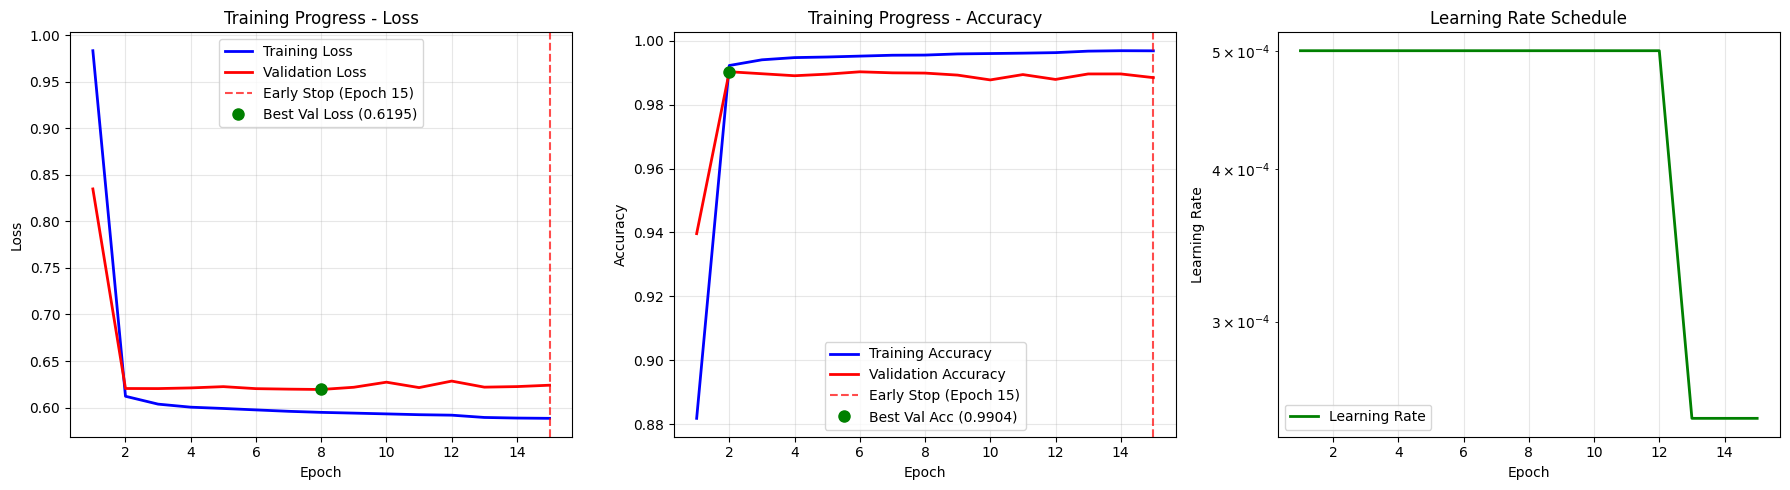


Starting comprehensive multi-class fault classification evaluation...
Found fault types in test data: [np.int64(0), np.int64(1), np.int64(2), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)]

Processing Fault Type 0

Evaluating Fault Type 0
Found 230400 samples for fault type 0
Created 223440 windows for evaluation


Applying Adaptive Kalman filter separately for 240 runs...



Results for Fault Type 0:
  Raw Accuracy:      0.9989
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    0.9994
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 0.9994
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 0.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 0:
              precision    recall  f1-score   support

         0.0     1.0000    1.0000    1.0000    223440

   micro avg     1.0000    1.0000    1.0000    223440
   macro avg     1.0000    1.0000    1.0000    223440
weighted avg     1.0000    1.0000    1.0000    223440

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 1

Evaluating Fault Type 1
Found 12000 samples for fault type 1
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 1:
  Raw Accuracy:      1.0000
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    1.0000
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 1.0000
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 1.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 1:
              precision    recall  f1-score   support

         1.0     1.0000    1.0000    1.0000     11565

    accuracy                         1.0000     11565
   macro avg     1.0000    1.0000    1.0000     11565
weighted avg     1.0000    1.0000    1.0000     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 2

Evaluating Fault Type 2
Found 12000 samples for fault type 2
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 2:
  Raw Accuracy:      1.0000
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    1.0000
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 1.0000
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 2.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 2:
              precision    recall  f1-score   support

         2.0     1.0000    1.0000    1.0000     11565

    accuracy                         1.0000     11565
   macro avg     1.0000    1.0000    1.0000     11565
weighted avg     1.0000    1.0000    1.0000     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 4

Evaluating Fault Type 4
Found 12000 samples for fault type 4
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 4:
  Raw Accuracy:      1.0000
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    1.0000
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 1.0000
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 4.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 4:
              precision    recall  f1-score   support

         4.0     1.0000    1.0000    1.0000     11565

    accuracy                         1.0000     11565
   macro avg     1.0000    1.0000    1.0000     11565
weighted avg     1.0000    1.0000    1.0000     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 5

Evaluating Fault Type 5
Found 12000 samples for fault type 5
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 5:
  Raw Accuracy:      1.0000
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    1.0000
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 1.0000
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 5.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 5:
              precision    recall  f1-score   support

         5.0     1.0000    1.0000    1.0000     11565

    accuracy                         1.0000     11565
   macro avg     1.0000    1.0000    1.0000     11565
weighted avg     1.0000    1.0000    1.0000     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 6

Evaluating Fault Type 6
Found 12000 samples for fault type 6
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 6:
  Raw Accuracy:      1.0000
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    1.0000
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 1.0000
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 6.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 6:
              precision    recall  f1-score   support

         6.0     1.0000    1.0000    1.0000     11565

    accuracy                         1.0000     11565
   macro avg     1.0000    1.0000    1.0000     11565
weighted avg     1.0000    1.0000    1.0000     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 7

Evaluating Fault Type 7
Found 12000 samples for fault type 7
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 7:
  Raw Accuracy:      1.0000
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    1.0000
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 1.0000
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 7.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 7:
              precision    recall  f1-score   support

         7.0     1.0000    1.0000    1.0000     11565

    accuracy                         1.0000     11565
   macro avg     1.0000    1.0000    1.0000     11565
weighted avg     1.0000    1.0000    1.0000     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 8

Evaluating Fault Type 8
Found 12000 samples for fault type 8
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 8:
  Raw Accuracy:      0.9905
  Filtered Accuracy: 0.9939
  Raw F1 (Macro):    0.9952
  Filtered F1 (Macro): 0.9970
  Raw F1 (Weighted): 0.9952
  Filtered F1 (Weighted): 0.9970
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 8.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 8:
              precision    recall  f1-score   support

         8.0     1.0000    0.9939    0.9970     11565

   micro avg     1.0000    0.9939    0.9970     11565
   macro avg     1.0000    0.9939    0.9970     11565
weighted avg     1.0000    0.9939    0.9970     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 10

Evaluating Fault Type 10
Found 12000 samples for fault type 10
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 10:
  Raw Accuracy:      0.9817
  Filtered Accuracy: 0.9905
  Raw F1 (Macro):    0.9907
  Filtered F1 (Macro): 0.9952
  Raw F1 (Weighted): 0.9907
  Filtered F1 (Weighted): 0.9952
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 10.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 10:
              precision    recall  f1-score   support

        10.0     1.0000    0.9905    0.9952     11565

   micro avg     1.0000    0.9905    0.9952     11565
   macro avg     1.0000    0.9905    0.9952     11565
weighted avg     1.0000    0.9905    0.9952     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 11

Evaluating Fault Type 11
Found 12000 samples for fault type 11
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 11:
  Raw Accuracy:      0.9941
  Filtered Accuracy: 0.9984
  Raw F1 (Macro):    0.9971
  Filtered F1 (Macro): 0.9992
  Raw F1 (Weighted): 0.9971
  Filtered F1 (Weighted): 0.9992
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 11.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 11:
              precision    recall  f1-score   support

        11.0     1.0000    0.9984    0.9992     11565

   micro avg     1.0000    0.9984    0.9992     11565
   macro avg     1.0000    0.9984    0.9992     11565
weighted avg     1.0000    0.9984    0.9992     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 12

Evaluating Fault Type 12
Found 12000 samples for fault type 12
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 12:
  Raw Accuracy:      0.8726
  Filtered Accuracy: 0.8808
  Raw F1 (Macro):    0.9320
  Filtered F1 (Macro): 0.9366
  Raw F1 (Weighted): 0.9320
  Filtered F1 (Weighted): 0.9366
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 12.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 12:
              precision    recall  f1-score   support

        12.0     1.0000    0.8808    0.9366     11565

   micro avg     1.0000    0.8808    0.9366     11565
   macro avg     1.0000    0.8808    0.9366     11565
weighted avg     1.0000    0.8808    0.9366     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 13

Evaluating Fault Type 13
Found 12000 samples for fault type 13
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 13:
  Raw Accuracy:      0.9656
  Filtered Accuracy: 0.9819
  Raw F1 (Macro):    0.9825
  Filtered F1 (Macro): 0.9909
  Raw F1 (Weighted): 0.9825
  Filtered F1 (Weighted): 0.9909
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 13.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 13:
              precision    recall  f1-score   support

        13.0     1.0000    0.9819    0.9909     11565

   micro avg     1.0000    0.9819    0.9909     11565
   macro avg     1.0000    0.9819    0.9909     11565
weighted avg     1.0000    0.9819    0.9909     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 14

Evaluating Fault Type 14
Found 12000 samples for fault type 14
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 14:
  Raw Accuracy:      1.0000
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    1.0000
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 1.0000
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 14.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 14:
              precision    recall  f1-score   support

        14.0     1.0000    1.0000    1.0000     11565

    accuracy                         1.0000     11565
   macro avg     1.0000    1.0000    1.0000     11565
weighted avg     1.0000    1.0000    1.0000     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 16

Evaluating Fault Type 16
Found 12000 samples for fault type 16
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 16:
  Raw Accuracy:      0.9925
  Filtered Accuracy: 0.9990
  Raw F1 (Macro):    0.9962
  Filtered F1 (Macro): 0.9995
  Raw F1 (Weighted): 0.9962
  Filtered F1 (Weighted): 0.9995
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 16.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 16:
              precision    recall  f1-score   support

        16.0     1.0000    0.9990    0.9995     11565

   micro avg     1.0000    0.9990    0.9995     11565
   macro avg     1.0000    0.9990    0.9995     11565
weighted avg     1.0000    0.9990    0.9995     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 17

Evaluating Fault Type 17
Found 12000 samples for fault type 17
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 17:
  Raw Accuracy:      0.9869
  Filtered Accuracy: 0.9838
  Raw F1 (Macro):    0.9934
  Filtered F1 (Macro): 0.9918
  Raw F1 (Weighted): 0.9934
  Filtered F1 (Weighted): 0.9918
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 17.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 17:
              precision    recall  f1-score   support

        17.0     1.0000    0.9838    0.9918     11565

   micro avg     1.0000    0.9838    0.9918     11565
   macro avg     1.0000    0.9838    0.9918     11565
weighted avg     1.0000    0.9838    0.9918     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 18

Evaluating Fault Type 18
Found 12000 samples for fault type 18
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 18:
  Raw Accuracy:      0.9783
  Filtered Accuracy: 0.9746
  Raw F1 (Macro):    0.9890
  Filtered F1 (Macro): 0.9871
  Raw F1 (Weighted): 0.9890
  Filtered F1 (Weighted): 0.9871
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 18.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 18:
              precision    recall  f1-score   support

        18.0     1.0000    0.9746    0.9871     11565

   micro avg     1.0000    0.9746    0.9871     11565
   macro avg     1.0000    0.9746    0.9871     11565
weighted avg     1.0000    0.9746    0.9871     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 19

Evaluating Fault Type 19
Found 12000 samples for fault type 19
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 19:
  Raw Accuracy:      0.9993
  Filtered Accuracy: 1.0000
  Raw F1 (Macro):    0.9997
  Filtered F1 (Macro): 1.0000
  Raw F1 (Weighted): 0.9997
  Filtered F1 (Weighted): 1.0000
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 19.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 19:
              precision    recall  f1-score   support

        19.0     1.0000    1.0000    1.0000     11565

    accuracy                         1.0000     11565
   macro avg     1.0000    1.0000    1.0000     11565
weighted avg     1.0000    1.0000    1.0000     11565

Visualizations saved to multiclass_evaluation_results/

Processing Fault Type 20

Evaluating Fault Type 20
Found 12000 samples for fault type 20
Created 11565 windows for evaluation


Applying Adaptive Kalman filter separately for 15 runs...



Results for Fault Type 20:
  Raw Accuracy:      0.9764
  Filtered Accuracy: 0.9703
  Raw F1 (Macro):    0.9881
  Filtered F1 (Macro): 0.9849
  Raw F1 (Weighted): 0.9881
  Filtered F1 (Weighted): 0.9849
  Raw ROC-AUC (Macro): nan
  Filtered ROC-AUC (Macro): nan
  Raw PR-AUC (Macro): nan
  Filtered PR-AUC (Macro): nan

Per-class ROC-AUC (Filtered):
  Class 20.0: N/A (issue calculating AUC)

Filtered Classification Report for Fault Type 20:
              precision    recall  f1-score   support

        20.0     1.0000    0.9703    0.9849     11565

   micro avg     1.0000    0.9703    0.9849     11565
   macro avg     1.0000    0.9703    0.9849     11565
weighted avg     1.0000    0.9703    0.9849     11565

Visualizations saved to multiclass_evaluation_results/

SUMMARY OF ALL MULTI-CLASS CLASSIFICATION RESULTS
 Fault_Type Raw_Accuracy Filtered_Accuracy Raw_F1_Macro Filtered_F1_Macro Raw_F1_Weighted Filtered_F1_Weighted Raw_ROC_AUC_Macro Filtered_ROC_AUC_Macro Raw_PR_AUC_Macro Filtered_

/tmp/ipython-input-1543074349.py:111: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()



OVERALL STATISTICS
Average Raw Accuracy: 0.9854 ± 0.0300
Average Filtered Accuracy: 0.9874 ± 0.0283
Average Raw F1 (Macro): 0.9924 ± 0.0160
Average Filtered F1 (Macro): 0.9935 ± 0.0150
Average Raw ROC-AUC (Macro): N/A (all NaN)
Average Filtered ROC-AUC (Macro): N/A (all NaN)
Average Raw PR-AUC (Macro): N/A (all NaN)
Average Filtered PR-AUC (Macro): N/A (all NaN)
Best Filtered Accuracy: 1.0000 (Fault 1)
Worst Filtered Accuracy: 0.8808 (Fault 12)
Best Filtered ROC-AUC: N/A (all NaN)
Worst Filtered ROC-AUC: N/A (all NaN)

All results saved to multiclass_evaluation_results/

EVALUATION COMPLETED SUCCESSFULLY!
Results saved to: multiclass_evaluation_results/
Summary CSV: multiclass_evaluation_results/multiclass_classification_summary.csv
Individual fault visualizations: multiclass_evaluation_results/fault_X_detailed_analysis.png
Summary visualizations: multiclass_evaluation_results/summary_*.png
Calculating overall test dataset performance...

CALCULATING OVERALL TEST DATASET PERFORMANCE
C

Applying Adaptive Kalman filter separately for 495 runs...



OVERALL TEST DATASET PERFORMANCE
Total Samples: 420,045
Number of Classes: 18

Overall Performance Metrics:
  Raw Accuracy:        0.9922
  Filtered Accuracy:   0.9937
  Raw F1 (Macro):      0.9871
  Filtered F1 (Macro): 0.9900
  Raw F1 (Weighted):   0.9922
  Filtered F1 (Weighted): 0.9937
  Raw F1 (Micro):      0.9922
  Filtered F1 (Micro): 0.9937
  Raw ROC-AUC (Macro): 0.9972
  Filtered ROC-AUC (Macro): 0.9977
  Raw PR-AUC (Macro):  0.9903
  Filtered PR-AUC (Macro): 0.9937
  Raw ROC-AUC (Weighted): 0.9974
  Filtered ROC-AUC (Weighted): 0.9972

Per-class ROC-AUC (Filtered):
  Class 0.0: 0.9968
  Class 1.0: 1.0000
  Class 2.0: 1.0000
  Class 4.0: 1.0000
  Class 5.0: 1.0000
  Class 6.0: 1.0000
  Class 7.0: 1.0000
  Class 8.0: 0.9994
  Class 10.0: 0.9976
  Class 11.0: 1.0000
  Class 12.0: 0.9995
  Class 13.0: 0.9940
  Class 14.0: 1.0000
  Class 16.0: 1.0000
  Class 17.0: 0.9939
  Class 18.0: 0.9921
  Class 19.0: 1.0000
  Class 20.0: 0.9848

Filtered Classification Report:
              

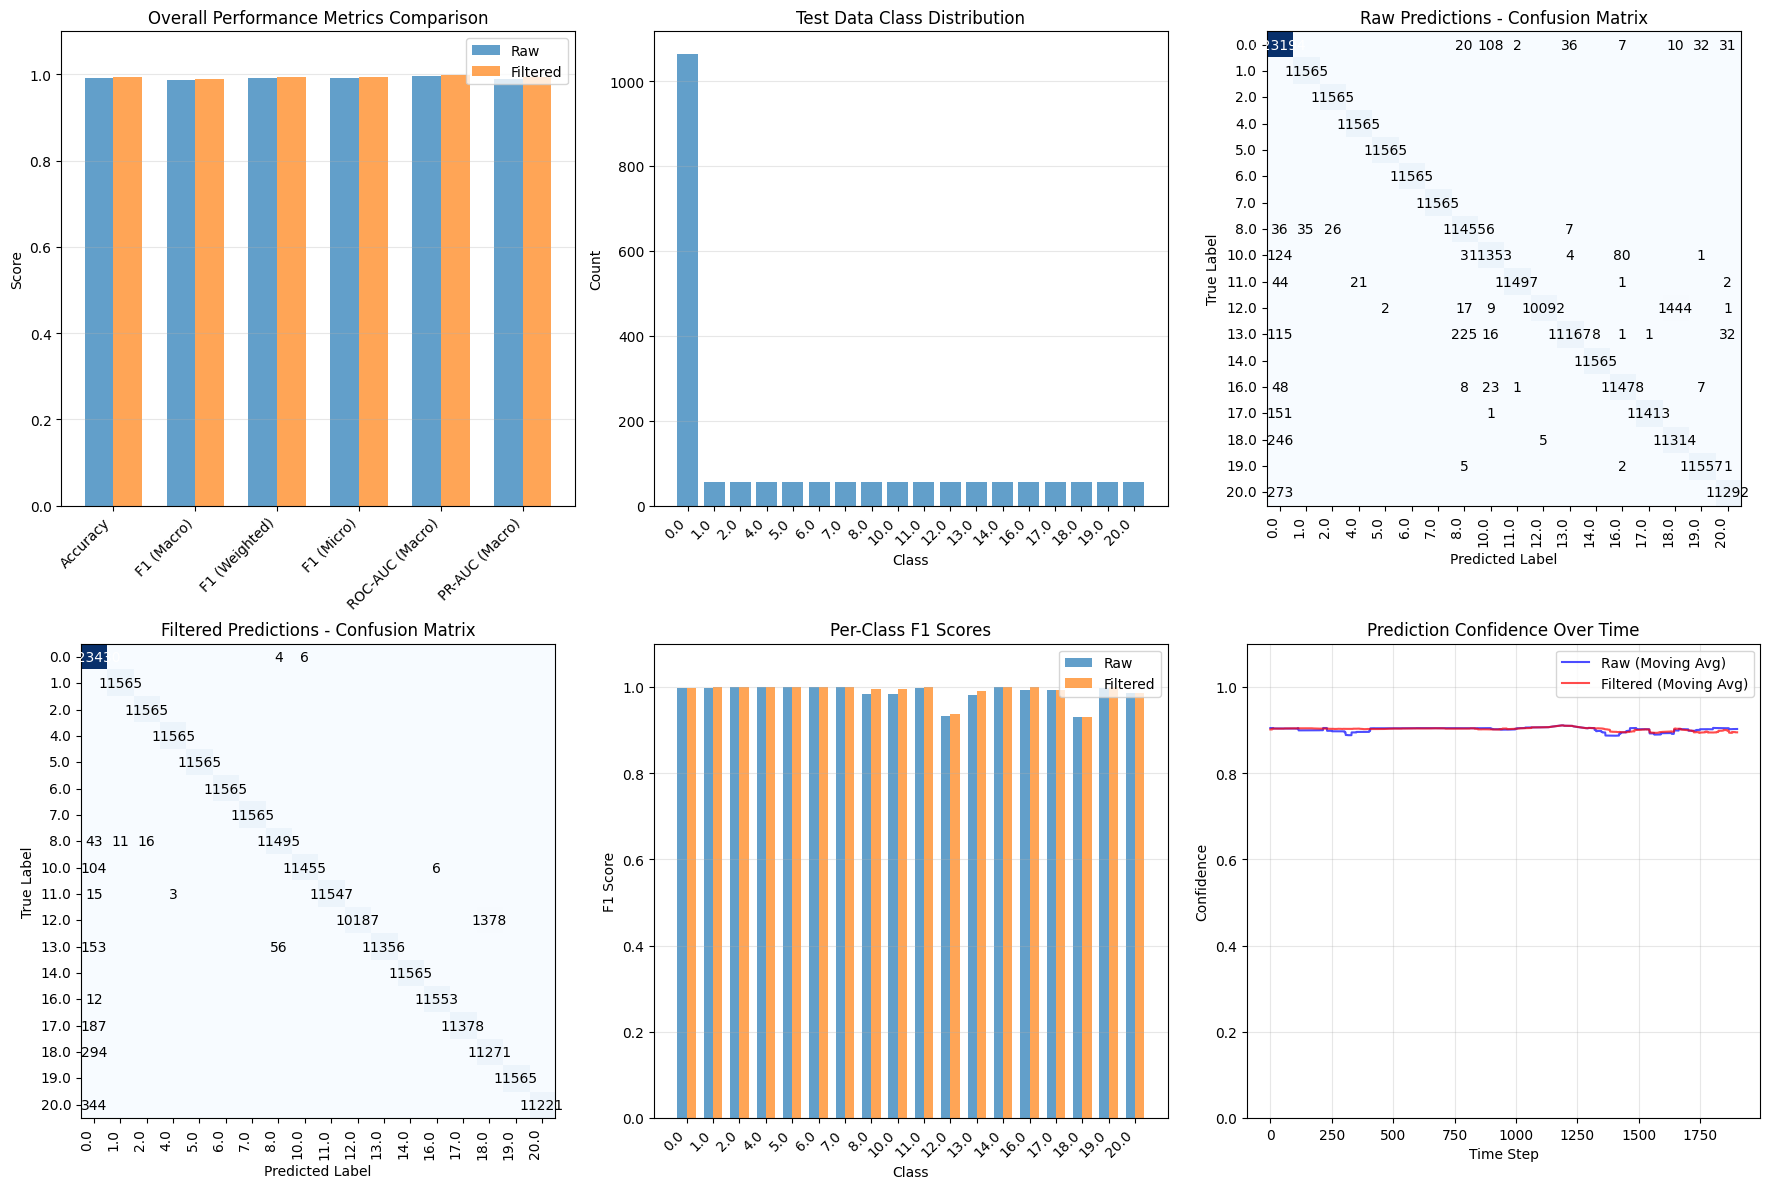


OVERALL TEST PERFORMANCE CALCULATION COMPLETED!
 Overall Filtered Accuracy: 0.9937
 Overall Filtered F1 (Macro): 0.9900
 Overall Filtered F1 (Weighted): 0.9937
 Overall Filtered F1 (Micro): 0.9937
 Overall Filtered ROC-AUC (Macro): 0.9977
 Overall Filtered PR-AUC (Macro): 0.9937
 Results saved to: multiclass_evaluation_results/overall_test_metrics.csv
 Visualization saved to: multiclass_evaluation_results/overall_test_performance.png


In [21]:
# Load model and run comprehensive evaluation
print("Loading trained model, scaler, and label encoder...")
classifier, scaler, label_encoder = load_trained_model()

if classifier is None or scaler is None or label_encoder is None:
    print("Error: Could not load model, scaler, or label encoder. Please ensure training was completed successfully.")
else:
    print("Model, scaler, and label encoder loaded successfully!")
    print(f"Number of classes: {classifier.num_classes}")

    # Display training progress if available
    if classifier.train_losses and classifier.val_losses:
        print(f"Training completed over {len(classifier.epochs)} epochs")
        print(f"Final training loss: {classifier.train_losses[-1]:.6f}")
        print(f"Final validation loss: {classifier.val_losses[-1]:.6f}")
        print(f"Final training accuracy: {classifier.train_accuracies[-1]:.4f}")
        print(f"Final validation accuracy: {classifier.val_accuracies[-1]:.4f}")

        if classifier.early_stopped_epoch:
            print(f"Early stopping was triggered at epoch {classifier.early_stopped_epoch}")
            print(f"Best validation loss: {classifier.best_val_loss:.6f}")
            print("This helped prevent overfitting!")

        # Enhanced training progress plot
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Loss plot with early stopping marker
        axes[0].plot(classifier.epochs, classifier.train_losses, 'b-', label='Training Loss', linewidth=2)
        axes[0].plot(classifier.epochs, classifier.val_losses, 'r-', label='Validation Loss', linewidth=2)

        # Mark early stopping point
        if classifier.early_stopped_epoch:
            axes[0].axvline(classifier.early_stopped_epoch, color='red', linestyle='--', alpha=0.7,
                           label=f'Early Stop (Epoch {classifier.early_stopped_epoch})')

        # Mark best validation loss
        best_val_idx = np.argmin(classifier.val_losses)
        axes[0].plot(classifier.epochs[best_val_idx], classifier.val_losses[best_val_idx], 'go',
                    markersize=8, label=f'Best Val Loss ({classifier.val_losses[best_val_idx]:.4f})')

        axes[0].set_xlabel('Epoch')
        axes[0].set_ylabel('Loss')
        axes[0].set_title('Training Progress - Loss')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)

        # Accuracy plot
        axes[1].plot(classifier.epochs, classifier.train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
        axes[1].plot(classifier.epochs, classifier.val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)

        if classifier.early_stopped_epoch:
            axes[1].axvline(classifier.early_stopped_epoch, color='red', linestyle='--', alpha=0.7,
                           label=f'Early Stop (Epoch {classifier.early_stopped_epoch})')

        # Mark best validation accuracy
        best_acc_idx = np.argmax(classifier.val_accuracies)
        axes[1].plot(classifier.epochs[best_acc_idx], classifier.val_accuracies[best_acc_idx], 'go',
                    markersize=8, label=f'Best Val Acc ({classifier.val_accuracies[best_acc_idx]:.4f})')

        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('Training Progress - Accuracy')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)

        # Learning rate plot
        if hasattr(classifier, 'learning_rates') and classifier.learning_rates:
            axes[2].plot(classifier.epochs, classifier.learning_rates, 'g-', label='Learning Rate', linewidth=2)
            axes[2].set_xlabel('Epoch')
            axes[2].set_ylabel('Learning Rate')
            axes[2].set_title('Learning Rate Schedule')
            axes[2].set_yscale('log')
            axes[2].legend()
            axes[2].grid(True, alpha=0.3)
        else:
            axes[2].text(0.5, 0.5, 'Learning Rate\nData Not Available',
                        ha='center', va='center', transform=axes[2].transAxes)
            axes[2].set_title('Learning Rate Schedule')

        plt.tight_layout()
        plt.savefig('final_training_progress_with_early_stopping.png', dpi=300, bbox_inches='tight')
        plt.show()

    # Set evaluation parameters
    LOOKBACK = 30
    BATCH_SIZE = 32
    OUTPUT_DIR = 'multiclass_evaluation_results'

    # Run comprehensive evaluation
    print("\nStarting comprehensive multi-class fault classification evaluation...")
    all_results, summary_df = evaluate_all_fault_types(
        classifier=classifier,
        df_test=df_test,
        scaler=scaler,
        label_encoder=label_encoder,
        lookback=LOOKBACK,
        batch_size=BATCH_SIZE,
        output_dir=OUTPUT_DIR
    )

    print(f"\n{'='*80}")
    print("EVALUATION COMPLETED SUCCESSFULLY!")
    print(f"{'='*80}")
    print(f"Results saved to: {OUTPUT_DIR}/")
    print(f"Summary CSV: {OUTPUT_DIR}/multiclass_classification_summary.csv")
    print(f"Individual fault visualizations: {OUTPUT_DIR}/fault_X_detailed_analysis.png")
    print(f"Summary visualizations: {OUTPUT_DIR}/summary_*.png")

# Execute Overall Test Performance Calculation
print("Calculating overall test dataset performance...")

# Check if model, scaler, and label encoder are available
if 'classifier' in locals() and 'scaler' in locals() and 'label_encoder' in locals():
    overall_test_results = calculate_overall_test_performance(
        classifier=classifier,
        df_test=df_test,
        scaler=scaler,
        label_encoder=label_encoder,
        lookback=LOOKBACK,
        batch_size=BATCH_SIZE
    )

    if overall_test_results:
        print(f"\n{'='*80}")
        print("OVERALL TEST PERFORMANCE CALCULATION COMPLETED!")
        print(f"{'='*80}")
        print(f" Overall Filtered Accuracy: {overall_test_results['filtered_accuracy']:.4f}")
        print(f" Overall Filtered F1 (Macro): {overall_test_results['filtered_f1_macro']:.4f}")
        print(f" Overall Filtered F1 (Weighted): {overall_test_results['filtered_f1_weighted']:.4f}")
        print(f" Overall Filtered F1 (Micro): {overall_test_results['filtered_f1_micro']:.4f}")
        print(f" Overall Filtered ROC-AUC (Macro): {overall_test_results['filtered_roc_auc_macro']:.4f}")
        print(f" Overall Filtered PR-AUC (Macro): {overall_test_results['filtered_pr_auc_macro']:.4f}")
        print(f" Results saved to: multiclass_evaluation_results/overall_test_metrics.csv")
        print(f" Visualization saved to: multiclass_evaluation_results/overall_test_performance.png")
    else:
        print("Failed to calculate overall test performance")
else:
    print("Error: Model, scaler, and label encoder not found. Please run the previous cells first.")

## Generate Final Figures for Paper

In [22]:
def plot_normalized_confusion_matrix(y_true, y_pred, label_encoder, title, save_path):
    """Generate normalized confusion matrix figure."""
    labels = np.arange(len(label_encoder.classes_))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-10)

    class_names = [str(int(c)) for c in label_encoder.classes_]

    fig, ax = plt.subplots(figsize=(12, 10))
    im = ax.imshow(cm_normalized, interpolation='nearest', cmap='Blues', vmin=0, vmax=1)
    cbar = ax.figure.colorbar(im, ax=ax, shrink=0.8)
    cbar.ax.tick_params(labelsize=10)

    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names, fontsize=9)
    ax.set_yticklabels(class_names, fontsize=9)
    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(title, fontsize=14)

    for i in range(len(class_names)):
        for j in range(len(class_names)):
            value = cm_normalized[i, j]
            if value > 0.0001:
                text_color = 'white' if value > 0.5 else 'black'
                ax.text(j, i, f'{value:.4f}', ha='center', va='center',
                       color=text_color, fontsize=8)

    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Confusion matrix saved to {save_path}")


def generate_final_figures(classifier, df_test, scaler, label_encoder, lookback=30, batch_size=32):
    # Prepare test data
    print("\nPreparing test data for confusion matrices...")
    X_test_windows, y_test_windows, run_indices = create_time_series_windows_from_df(
        df_test, scaler, label_encoder, lookback=lookback,
        group_cols=('faultNumber', 'simulationRun'),
        return_run_indices=True
    )

    print(f"Test windows shape: {X_test_windows.shape}")

    # Get predictions
    print("Getting predictions...")
    raw_predictions, raw_probabilities, filtered_predictions, filtered_probabilities = classifier.predict(
        X_test_windows, batch_size=batch_size, use_kalman=True, run_indices=run_indices
    )

    y_true = y_test_windows.numpy()

    # Raw Confusion Matrix
    print("\nGenerating Figure 3a: Raw Predictions Confusion Matrix...")
    plot_normalized_confusion_matrix(
        y_true, raw_predictions, label_encoder,
        'Normalized Confusion Matrix of Raw Predictions (Transformer)',
        'figure3a_confusion_matrix_raw.png'
    )

    # Filtered Confusion Matrix
    print("\nGenerating Figure 3b: Filtered Predictions Confusion Matrix...")
    plot_normalized_confusion_matrix(
        y_true, filtered_predictions, label_encoder,
        'Normalized Confusion Matrix of the Final Filtered Model (TransKal)',
        'figure3b_confusion_matrix_filtered.png'
    )

    return raw_predictions, filtered_predictions, y_true


Preparing test data for confusion matrices...
Test windows shape: torch.Size([420045, 30, 52])
Getting predictions...


Applying Adaptive Kalman filter separately for 495 runs...



Generating Figure 3a: Raw Predictions Confusion Matrix...


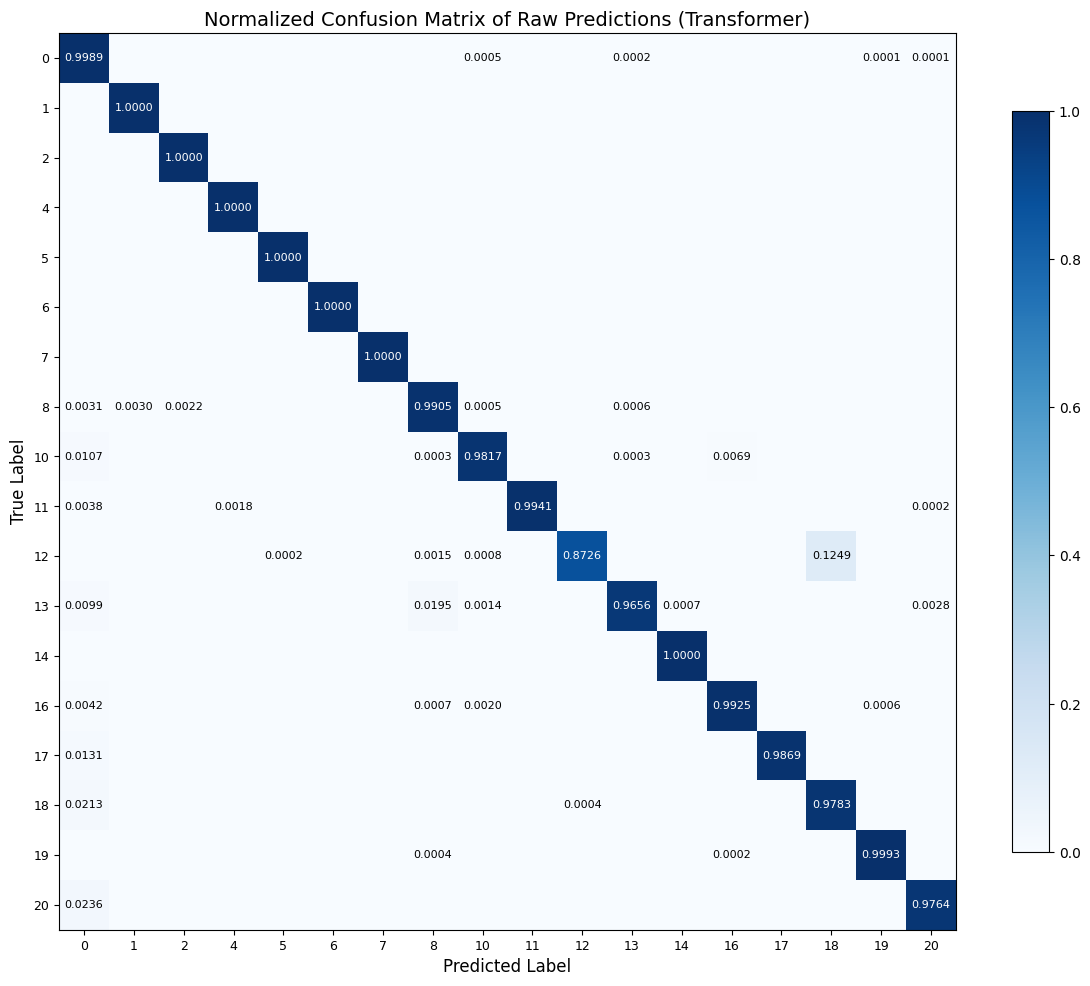

Confusion matrix saved to figure3a_confusion_matrix_raw.png

Generating Figure 3b: Filtered Predictions Confusion Matrix...


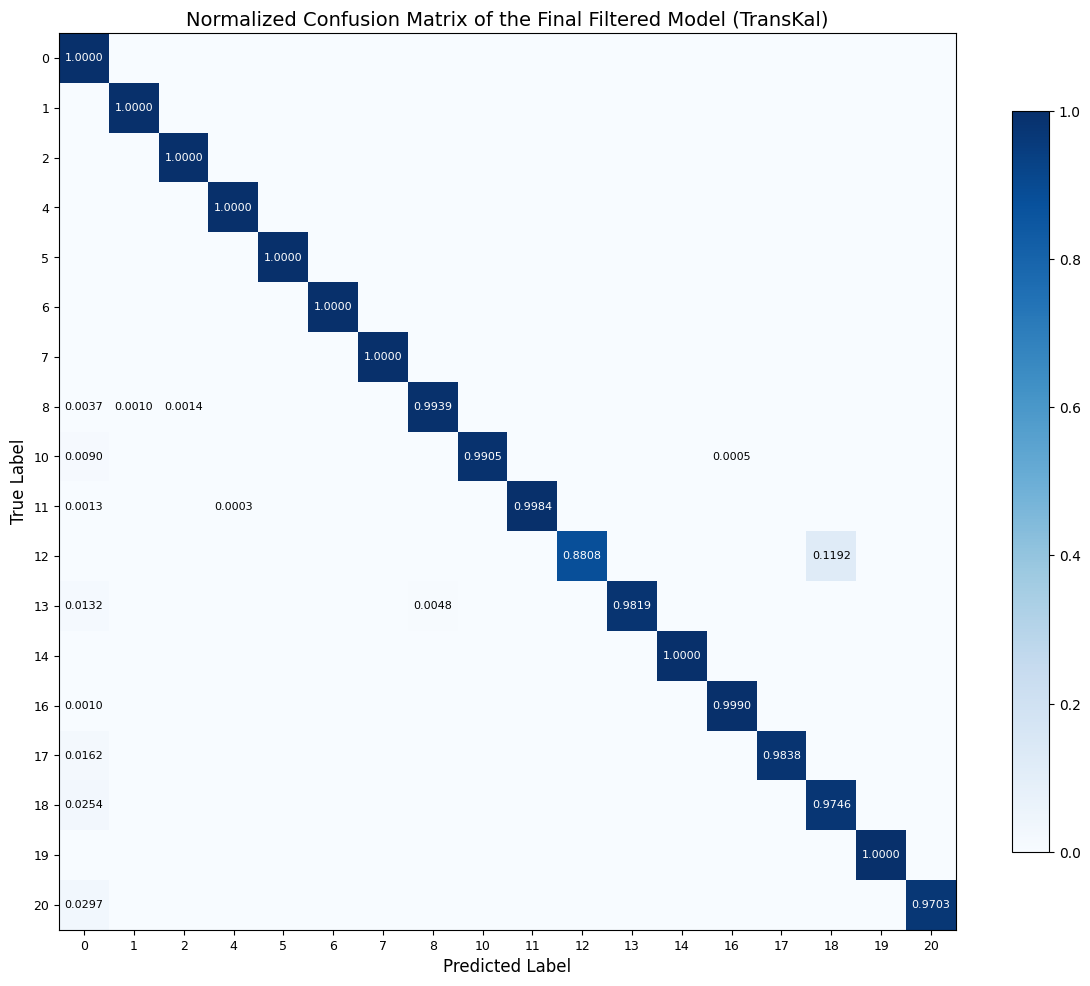

Confusion matrix saved to figure3b_confusion_matrix_filtered.png


In [23]:
# Generate final figures for the paper
if classifier is not None and scaler is not None and label_encoder is not None:
    raw_preds, filtered_preds, y_true = generate_final_figures(
        classifier, df_test, scaler, label_encoder,
        lookback=LOOKBACK, batch_size=BATCH_SIZE
    )

In [24]:
print(f'Finished at {time.asctime()}.')
print(f'Elapsed time = {time.time() - t0:1.0f} seconds.')

Finished at Tue Dec 23 05:24:08 2025.
Elapsed time = 1585 seconds.


## Bibliography

<a id="1">1. Q. Sun and Z. Ge. Generalized transformer in fault diagnosis of Tennessee Eastman process. Neural Computing and Applications, 34:8575–8586, 2022.

<a id="2">2. D. M. Farid, L. Zhang, C. M. Rahman, M. A. Hossain, and R. Strachan. A linear model based on Kalman filter for improving neural network classification performance. Expert Systems with Applications, 49:112–121, 2016.